# **New Zealand flood study - exploratory analysis**

**Data sources:**

- MSWEP gridded precipitation data: http://www.gloh2o.org/mswep/
- Gridded elevation data: https://download.gebco.net/
- NZ administrative shapefiles: https://datafinder.stats.govt.nz (Regional Council 2023 Clipped (generalised), New Zealand)
- Hydro catchments: https://www.hydrosheds.org/products/hydrosheds
- Station data from https://cliflo.niwa.co.nz/

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

# method to get closest point from MSWEP gridded data
def nearest_px(lon,lat,da):
    dist2 = (da.lon - lon)**2 + (da.lat - lat)**2   # get squared distance from (lon, lat) to each point
    dist2 = dist2.where(~np.isnan(da))   # exclude any cells where the gridded data is NaN
    return da.where(dist2 == dist2.min()).mean(["lat", "lon"])

In [3]:
# # extract necessary data from MSWEP daily files
# for y in range(1979, 2021):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179))
#     ds.to_netcdf("data/mswep-daily_"+str(y)+".nc")
    
# for y in range(2021, 2024):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179))
#     ds.to_netcdf("data/mswep-daily_"+str(y)+".nc")

In [349]:
nino = pd.read_csv("../90_data/nino3.4_rel_monthly.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "nino34"], index_col = 0, parse_dates = True)
nino = nino.loc[[m in [12,1,2] for m in nino.index.month]].resample("AS-JUL", label = "right").mean()
nino.index = nino.index.year

rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day.rename(time = "year")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())
rx2day = rx2day.where(regionmask.mask_3D_geopandas(regions, rx2day.lon, rx2day.lat).sum("region") == 1)

hg = gpd.read_file("sf_hawkes-gisborne")

In [349]:
nino = pd.read_csv("../90_data/nino3.4_rel_monthly.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "nino34"], index_col = 0, parse_dates = True)
nino = nino.loc[[m in [12,1,2] for m in nino.index.month]].resample("AS-JUL", label = "right").mean()
nino.index = nino.index.year

rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day.rename(time = "year")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())
rx2day = rx2day.where(regionmask.mask_3D_geopandas(regions, rx2day.lon, rx2day.lat).sum("region") == 1)

hg = gpd.read_file("sf_hawkes-gisborne")

## **Event map (MSWEP)**

In [67]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

# adjust for local time zone
pr_nz = pr.assign_coords(time = [t + np.timedelta64(13, "h") for t in pr.time.values])

# extract event itself
pr_1314 = pr_nz.sel(time = slice("2023-02-13", None)).sum("time").assign_attrs(units = "mm").sel(lat = slice(-34, -42), lon = slice(172, 179))
pr_utc = pr.resample(time = "D").sum().rolling(time = 2, center = False).sum().sel(time = "2023-02-13").assign_attrs(units = "mm")

### **3-hourly maps**

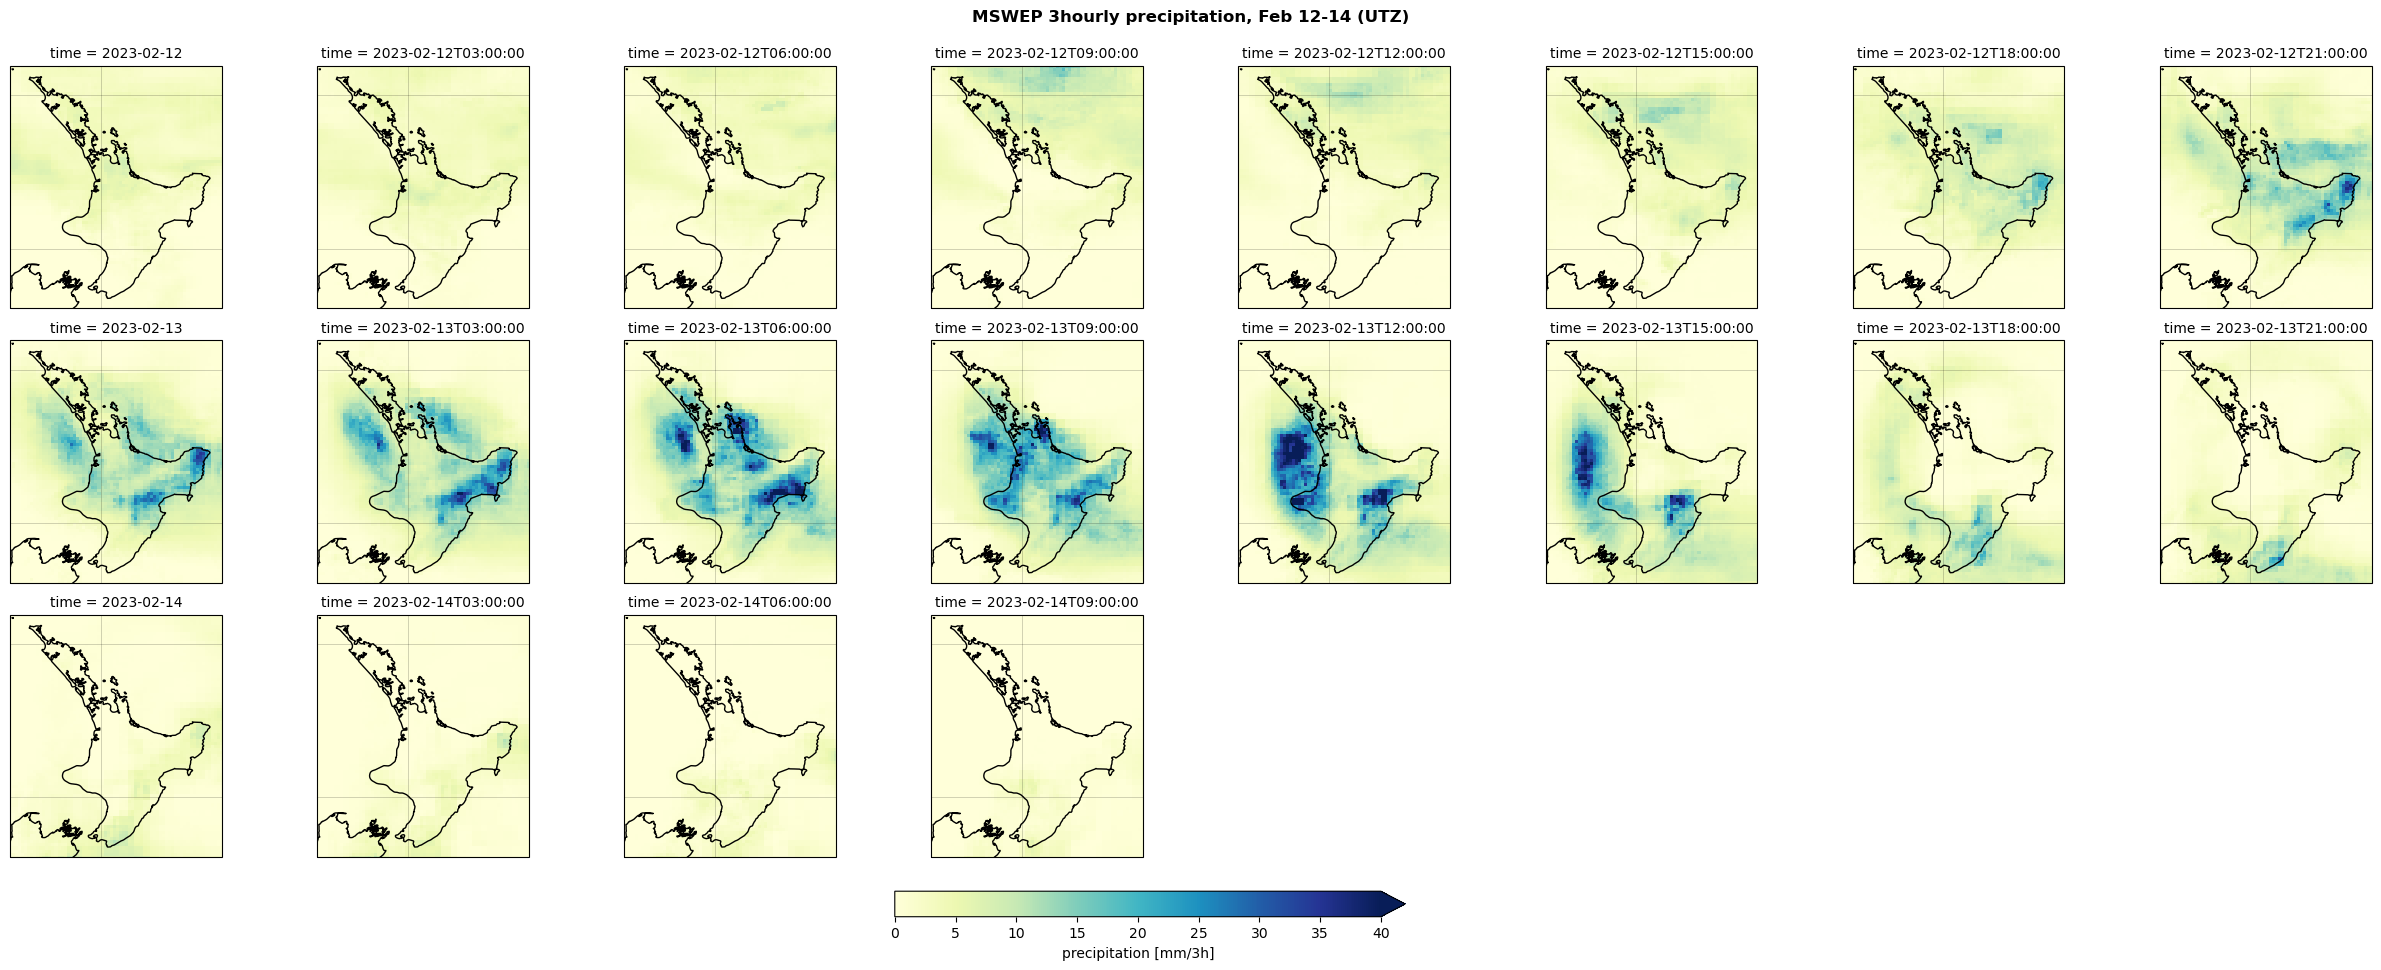

In [3]:
# UTC
pr.sel(time = slice("2023-02-12", None)).plot(col = "time", col_wrap = 8, cmap = "YlGnBu", vmax = 40, 
                                              subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                             "extent" : (pr.lon.min().values, pr.lon.max().values, pr.lat.min().values, pr.lat.max().values)},
                                              cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.suptitle("MSWEP 3hourly precipitation, Feb 12-14 (UTZ)", y = 1.025, fontweight = "bold")

plt.savefig("mswep-3hourly-utc.png")

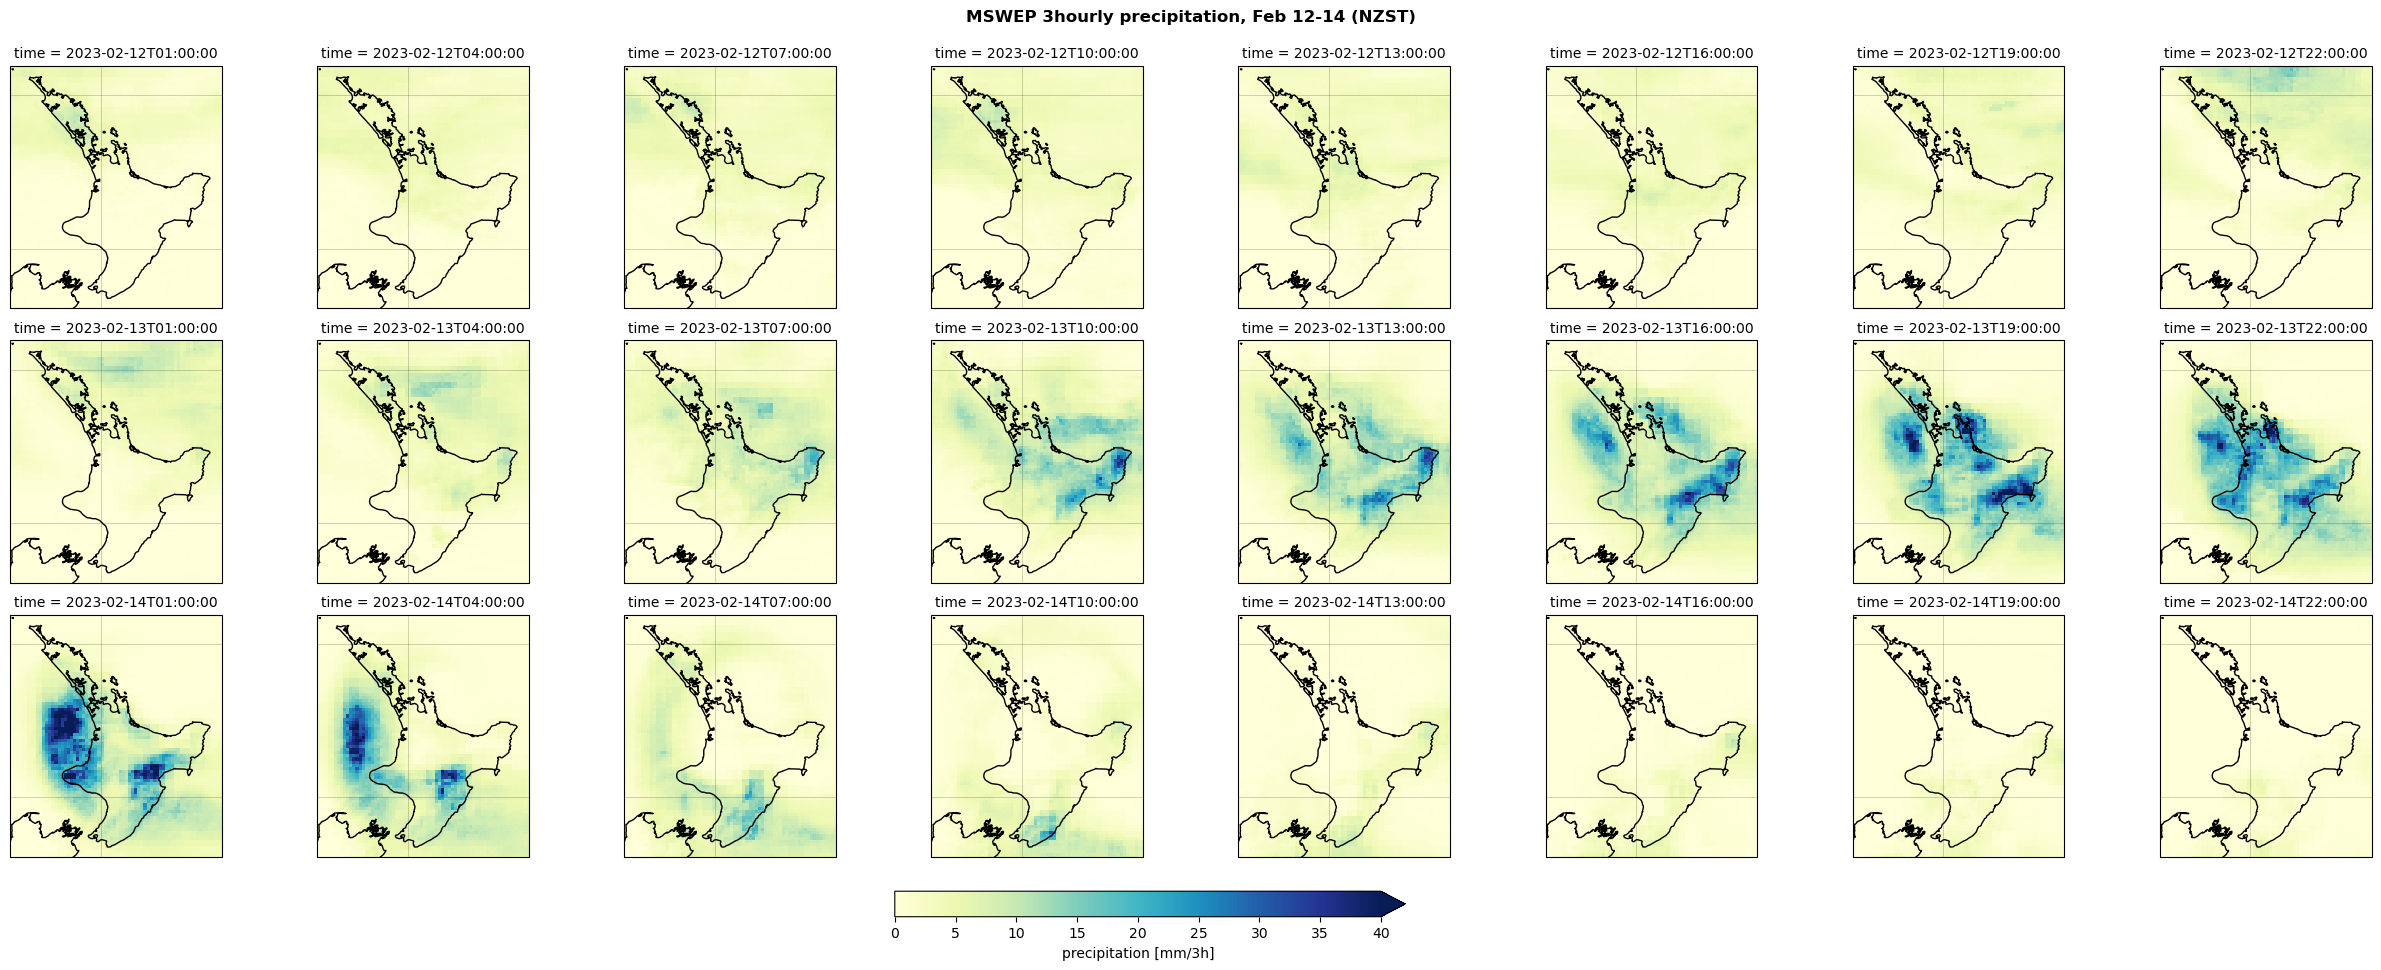

In [4]:
pr_nz.sel(time = slice("2023-02-12", None)).plot(col = "time", col_wrap = 8, cmap = "YlGnBu", vmax = 40, 
                                              subplot_kws = {"projection" : cartopy.crs.PlateCarree(),
                                                             "extent" : (pr.lon.min().values, pr.lon.max().values, pr.lat.min().values, pr.lat.max().values)},
                                              cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04})
for ax in plt.gcf().axes[:-1]:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.suptitle("MSWEP 3hourly precipitation, Feb 12-14 (NZST)", y = 1.025, fontweight = "bold")

plt.savefig("mswep-3hourly-nzst.png")

### **North Island 2-day precip**

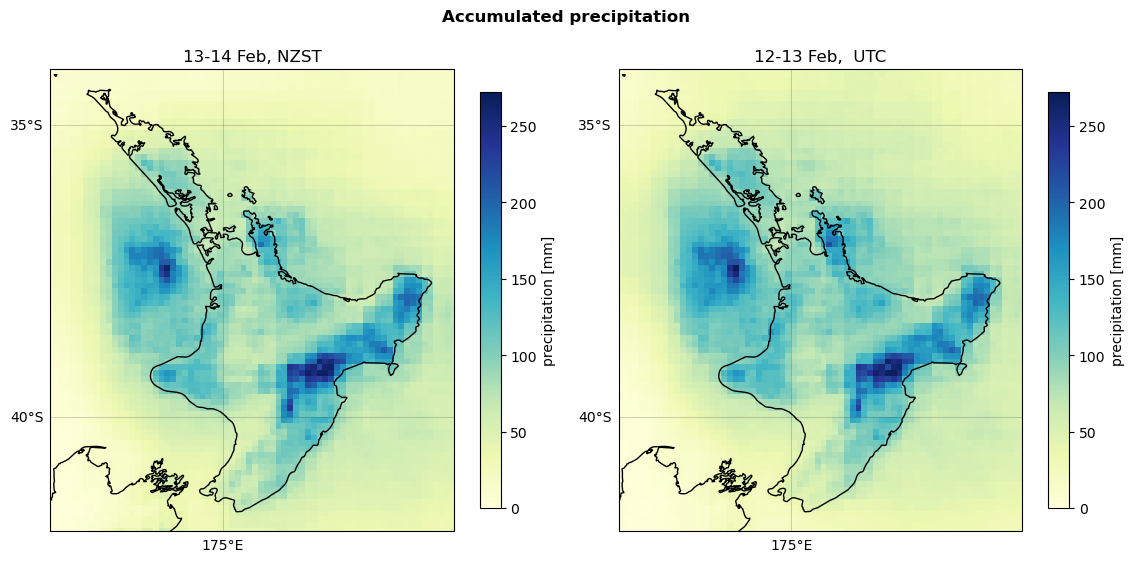

In [5]:
# 2-day rolling precip in UTC captures precip from 1pm on 12th-1pm on 14th

fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.1)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, vmax = 272, cbar_kwargs = {"shrink" : 0.9}); axs[0].set_title("13-14 Feb, NZST")
pr_utc.plot(ax = axs[1], cmap = "YlGnBu", vmin = 0, vmax = 272, cbar_kwargs = {"shrink" : 0.9}); axs[1].set_title("12-13 Feb,  UTC")

plt.suptitle("Accumulated precipitation", fontweight = "bold")
for ax in axs:
    ax.coastlines()
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, draw_labels = ["bottom", "left"], color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.savefig("mswep-northisland-pr2day.png")

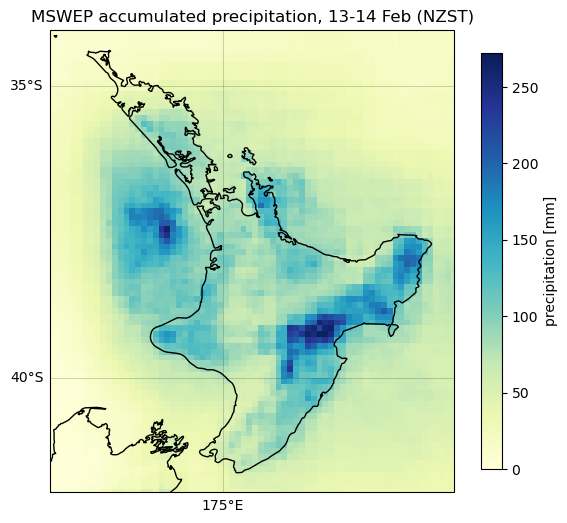

In [71]:
# 2-day rolling precip in UTC captures precip from 1pm on 12th-1pm on 14th

fig, ax = plt.subplots(ncols = 1, figsize = (7,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.1)

pr_1314.plot(ax = ax, cmap = "YlGnBu", vmin = 0, vmax = 272, cbar_kwargs = {"shrink" : 0.9})
ax.set_title("MSWEP accumulated precipitation, 13-14 Feb (NZST)")

ax.coastlines()
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, draw_labels = ["bottom", "left"], color='black', alpha=0.25, xlocs = range(165, 180, 5), ylocs = range(-30,-50,-5))
    
plt.savefig("mswep-event-northisland.png")

---
## **Define study region**

In [260]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

# adjust for local time zone
pr_nz = pr.assign_coords(time = [t + np.timedelta64(13, "h") for t in pr.time.values])

# extract event itself
pr_1314 = pr_nz.sel(time = slice("2023-02-13", None)).sum("time").assign_attrs(units = "mm").sel(lat = slice(-34, -42), lon = slice(172, 179))
pr_utc = pr.resample(time = "D").sum().rolling(time = 2, center = False).sum().sel(time = "2023-02-13").assign_attrs(units = "mm")

In [269]:
regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())
# hwy1 = gpd.read_file("sf/nz_roads/").to_crs(cartopy.crs.PlateCarree())
# hwy1 = hwy1.loc[hwy1.name == "State Highway 1"]

elev = xr.open_dataset("data/gebco_elevation.nc").elevation

### **Hawkes Bay & Gisborne/Tarawhiti**

In [ ]:
# merge selected region
sf = regions.loc[[4,5]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf = sf[sf.geometry.area == sf.geometry.area.max()]
sf.to_file("sf_hawkes-gisborne")

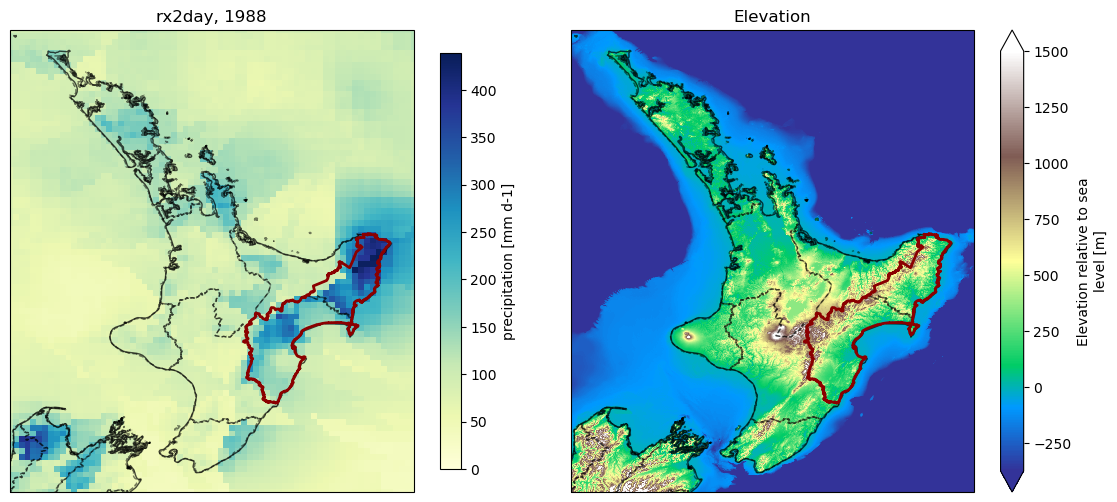

In [ ]:
pr_2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum()
bowler = pr_2day.groupby("time.year")[1988].max("time")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

bowler.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("rx2day, 1988")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
    
    plt.savefig("candidate-region-1.png")

#### **Points from shapefile**

In [16]:
hg = gpd.read_file("sf_hawkes-gisborne")
px = hg.geometry.apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))

In [22]:
px.to_csv("sf_HawkesBay-Gisborne.txt", sep = " ", index = False)

### **Hawkes Bay & Gisborne/Tarawhiti, Bay of Plenty**

In [ ]:
# merge selected region
sf2 = regions.loc[[3,4,5]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf2 = sf2[sf2.geometry.area == sf2.geometry.area.max()]
sf2.to_file("sf_hawkes-gisborne-plenty")

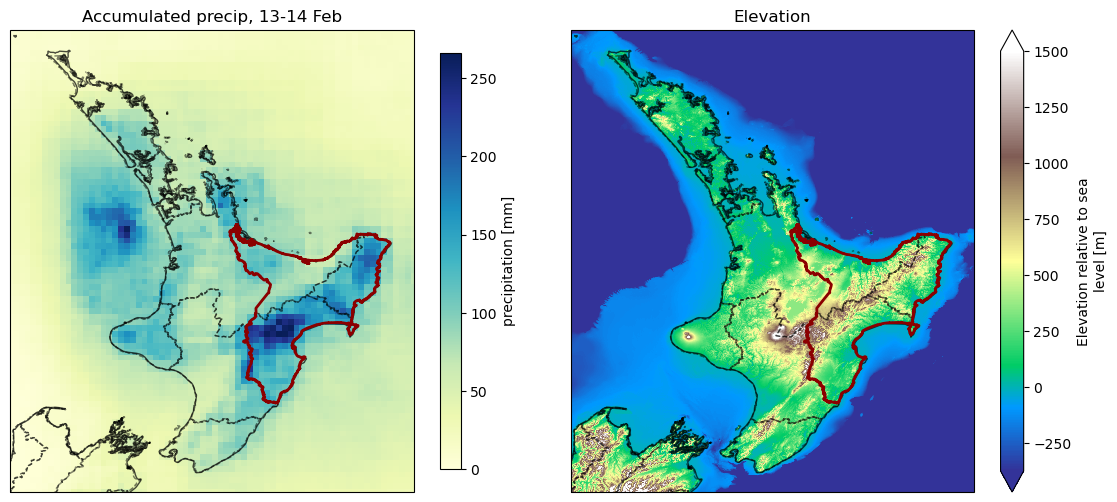

In [14]:
hgp = gpd.read_file("sf_hawkes-gisborne-plenty")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("Accumulated precip, 13-14 Feb")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    hgp.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
    
plt.savefig("candidate-region-2.png")

### **NE coast of North Island**

Extend the region to include the whole coastal region, as suggested by Luke

In [38]:
nz = gpd.read_file("sf/hybas_02/").loc[[6],:]

basin05 = gpd.read_file("sf/hybas_05/").clip(nz).to_crs(cartopy.crs.PlateCarree())
basin05 = basin05[basin05.geometry.centroid.y == basin05.geometry.centroid.y.max()]
basin05 = basin05.dissolve().explode(index_parts = True)
basin05 = basin05[basin05.geometry.area == basin05.geometry.area.max()]
basin05.to_file("sf_ne-coast")

In [54]:
# merge selected region
sf2 = regions.loc[[1,2]].dissolve().explode(index_parts = True)

# get the single largest polygon as boundary
sf2 = sf2[sf2.geometry.area == sf2.geometry.area.max()]
sf2.to_file("sf_northland-auckland")

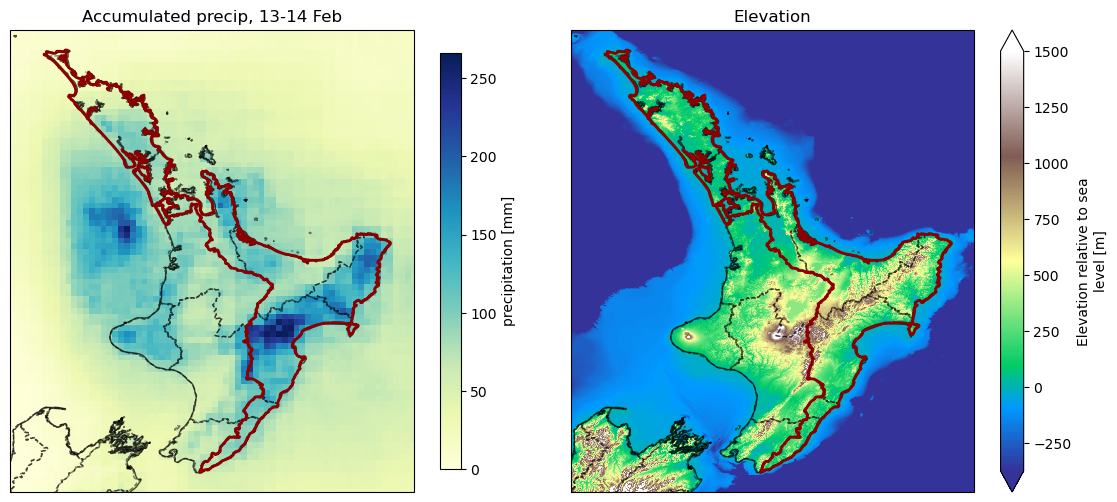

In [16]:
ne = gpd.read_file("sf_ne-coast")

cbar_kwargs = {"shrink" : 0.9}
fig, axs = plt.subplots(ncols = 2, figsize = (14,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (pr_1314.lon.min().values, pr_1314.lon.max().values, pr_1314.lat.min().values, pr_1314.lat.max().values)})
plt.subplots_adjust(wspace = 0.07)

pr_1314.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, cbar_kwargs = cbar_kwargs)
axs[0].set_title("Accumulated precip, 13-14 Feb")

elev.plot(ax = axs[1], cmap = "terrain", vmin = -375, vmax = 1500)
axs[1].set_title("Elevation")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.5)
    ne.boundary.plot(ax = ax, lw = 2, color = "darkred", label = "Suggested region")
        
plt.savefig("candidate-region-NEcoast.png")

### **3hourly precip in each proposed region**

In [22]:
hg = gpd.read_file("sf_hawkes-gisborne/")
hgp = gpd.read_file("sf_hawkes-gisborne-plenty/")
ne = gpd.read_file("sf_ne-coast")
na = gpd.read_file("sf_northland-auckland")

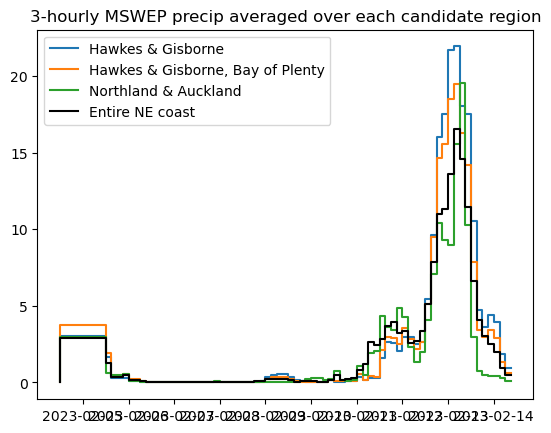

In [21]:
pr = xr.open_mfdataset("/home/clair/Data/mswep_3hr/*.nc").sel(lat = slice(-34, -42), lon = slice(172, 179)).precipitation.load()

pr_hg, pr_hgp, pr_ne, pr_na = [pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]) for sf in [hg, hgp, ne, na]]

plt.step(pr_hg.time, pr_hg, label = "Hawkes & Gisborne")
plt.step(pr_hgp.time, pr_hgp, label = "Hawkes & Gisborne, Bay of Plenty")
plt.step(pr_na.time, pr_na, label = "Northland & Auckland")
plt.step(pr_ne.time, pr_ne, label = "Entire NE coast", color = "k")

plt.title("3-hourly MSWEP precip averaged over each candidate region")
plt.legend()

---
## **MSWEP rx2day**

In [2]:
rx2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day").assign_attrs(units = "mm")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year+1)
rx2day.to_netcdf("data/mswep_rx2day.nc")

# also useful to check trend without Cyclone Gabrielle
rx2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.sel(time = slice(None, "2023-02-11")).rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().rename("rx2day").assign_attrs(units = "mm")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year+1)
rx2day.to_netcdf("data/mswep_rx2day_excluding-event.nc")

Text(0.5, 0.98, 'rx2day Jun22-Feb23 with & without Cyclone Gabrielle')

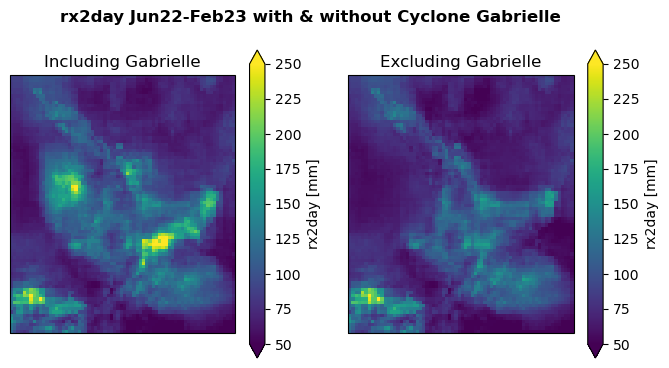

In [48]:
incl = xr.open_dataset("data/mswep_rx2day.nc").rx2day
excl = xr.open_dataset("data/mswep_rx2day_excluding-event.nc").rx2day

fig, axs = plt.subplots(ncols = 2, figsize = (8,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

incl.sel(time = 2023).plot(ax = axs[0], vmin = 50, vmax = 250)
axs[0].set_title("Including Gabrielle")
excl.sel(time = 2023).plot(ax = axs[1], vmin = 50, vmax = 250)
axs[1].set_title("Excluding Gabrielle")

plt.suptitle("rx2day Jun22-Feb23 with & without Cyclone Gabrielle", fontweight = "bold")

### **Spatial pattern**

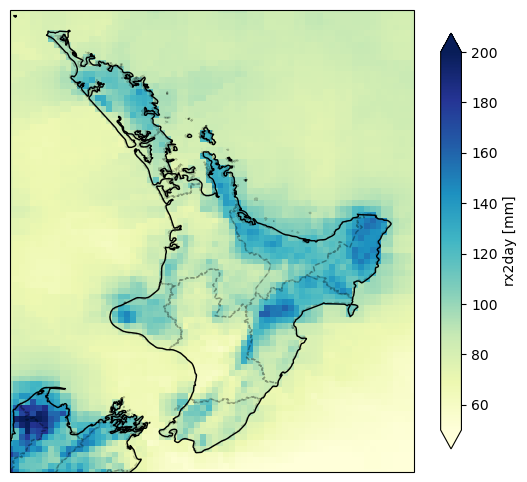

In [3]:
rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day
regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())

cbar_kwargs = {"shrink" : 0.9}

fig, ax = plt.subplots(ncols = 1, figsize = (7,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (rx2day.lon.min().values, rx2day.lon.max().values, rx2day.lat.min().values, rx2day.lat.max().values)})

rx2day.mean("time").plot(ax = ax, cmap = "YlGnBu", vmin = 50, vmax = 200, cbar_kwargs = cbar_kwargs)

ax.coastlines(color = "k")
regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)

plt.savefig("mswep-spatial-pattern.png")

### **Check cutpoint for water year**

Text(0.5, 1.0, '')

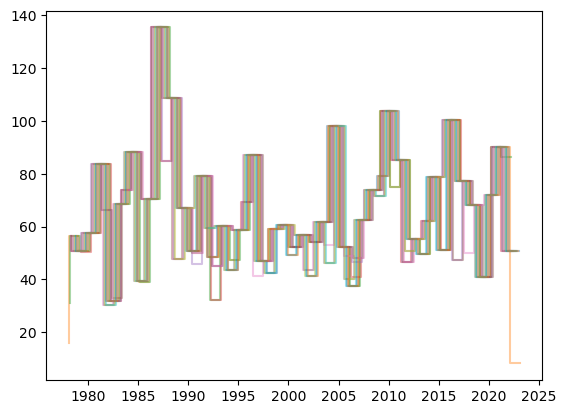

In [42]:
# exact timing of water year makes very little difference
pr_2day = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation.rolling(time = 2, center = False).sum()
hg = pr.where(regionmask.mask_3D_geopandas(gpd.read_file("sf_hawkes-gisborne/"), pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).load()

zz = [hg.resample(time = "AS-"+datetime(2022,m+1,1).strftime("%b").upper()).max() for m in range(12)]

[plt.step(da.time, da, alpha = 0.4) for da in zz]
plt.title("")

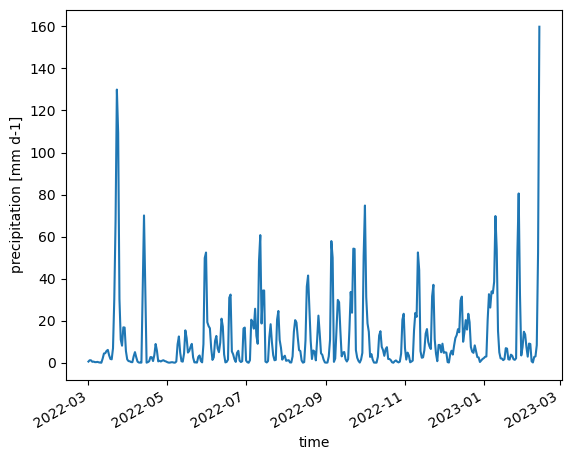

In [161]:
# most extreme event is still this one, even if we include the entire preceding year
hg.sel(time = slice("2022-03", None)).plot()

### **Time series for climate explorer**

In [70]:
# work with MSWEP daily precip (UTC so some care needed when talking about event times)
pr = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation

hg = gpd.read_file("sf_hawkes-gisborne/")
rm = regionmask.mask_3D_geopandas(hg, pr.lon, pr.lat).squeeze(drop = True)
      
csv_fnm = "ts/NZ-flood_rx2day_mswep.dat"   

# create extra header lines for upload to Climate Explorer
str1 = "# contact :: MSWEP rx2day (Hawkes Bay & Gisborne) New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
str2 = "# rx2day [mm] 2-day accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year rx2day"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

# get average precip over region of interest, accumulate over two days, get annual maximum
pr_daily = pr.where(rm == 1).mean(["lat", "lon"])
rx2day = pr_daily.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().dropna("time", "any")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year + 1)

rx2day.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [73]:
# for reference only: remove Cyclone Gabrielle & create ts
csv_fnm = "ts/NZ-flood_rx2day_mswep_without-Gabrielle.dat"   

# header lines
str1 = "# contact :: MSWEP rx2day (Hawkes Bay & Gisborne - EXCLUDING CYCLONE GABRIELLE) New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
str2 = "# rx2day [mm] 2-day accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year rx2day"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

pr_daily = pr.sel(time = slice(None, "2023-02-11")).where(rm == 1).mean(["lat", "lon"])
rx2day = pr_daily.rolling(time = 2, center = False).sum().resample(time = "AS-JUL").max().dropna("time", "any")
rx2day = rx2day.assign_coords(time = rx2day.time.dt.year + 1)

rx2day.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [10]:
# also get daily accumulation for the region
pr = xr.open_mfdataset("data/mswep-daily_*.nc").precipitation
pr_daily = pr.where(regionmask.mask_3D_geopandas(gpd.read_file("sf_hawkes-gisborne/"), pr.lon, pr.lat).squeeze(drop = True) == 1).mean(["lat", "lon"])
pr_daily.to_netcdf("data/mswep_daily-ts.nc")

### **Fitted model per grid cell**

Model fitting is quite slow, so try to avoid re-fitting

In [44]:
# # fit fixed-dispersion GEV to each grid cell
# mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day
# gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year").to_xarray().sel(year = mswep.time).gmst

# mfit = ns_mapfit(gev, "fixeddisp", mswep, gmst)
# mfit.to_netcdf("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")

In [54]:
# # also fit without Cyclone Gabrielle, in case of high leverage
# mswep_excl = xr.open_dataset("data/mswep_rx2day_excluding-event.nc").rx2day
# gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = "year").to_xarray().sel(year = mswep.time).gmst

# mfit_excl = ns_mapfit(gev, "fixeddisp", mswep_excl, gmst)
# mfit_excl.to_netcdf("fitted_models/mswep_rx2day_fitted-gev-fixeddisp_excluding-event2.nc")

#### **Check fitted model**

In [ ]:
fitted = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = fitted.covariate

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, fitted.lon, fitted.lat).sum("region")
mfit = fitted.ml_fit.assign_attrs(units = "").where(lsm == 1)

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"nll" : {"cmap" : "viridis"},
               "mu" : {"cmap" : "YlGnBu"},
               "sigma" : {"cmap" : "YlGnBu"},
               "alpha" : {"cmap" : "RdBu", "vmin" : -50, "vmax" : 50},
               "shape" : {"cmap" : "PuOr", "vmin" : -0.5, "vmax" : 0.5}}

for i in range(5):
        par = mfit.pars.values[i+1]
        cbar = axs[i].pcolormesh(mfit.lon, mfit.lat, mfit.sel(pars = par), **plot_kwargs[par])
        plt.colorbar(cbar, ax = axs[i], location = "bottom", shrink = 0.9, fraction = 0.03, pad = 0.04)
        axs[i].set_title(par)
        axs[i].coastlines(color = "k")
        regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
        
plt.suptitle("Fitted parameters (MSWEP including Cyclone Gabrielle)")
# huge trend in Hawkes Bay region (Esk Valley?). Confirm against stations.

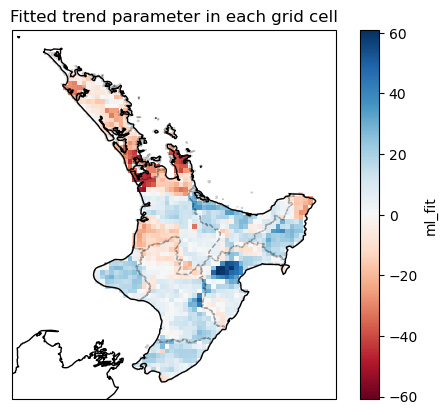

In [195]:
mfit.sel(pars = "alpha").plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "RdBu")

ax = plt.gcf().axes[0]

ax.set_title("Fitted trend parameter in each grid cell")
ax.coastlines(color = "k")
regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)

plt.savefig("mswep-fitted-trend-parameter.png")

#### **Sensitivity of grid-cell fits to inclusion of Cyclone Gabrielle**

Text(0.5, 0.98, 'Fitted parameters (MSWEP excluding Cyclone Gabrielle)')

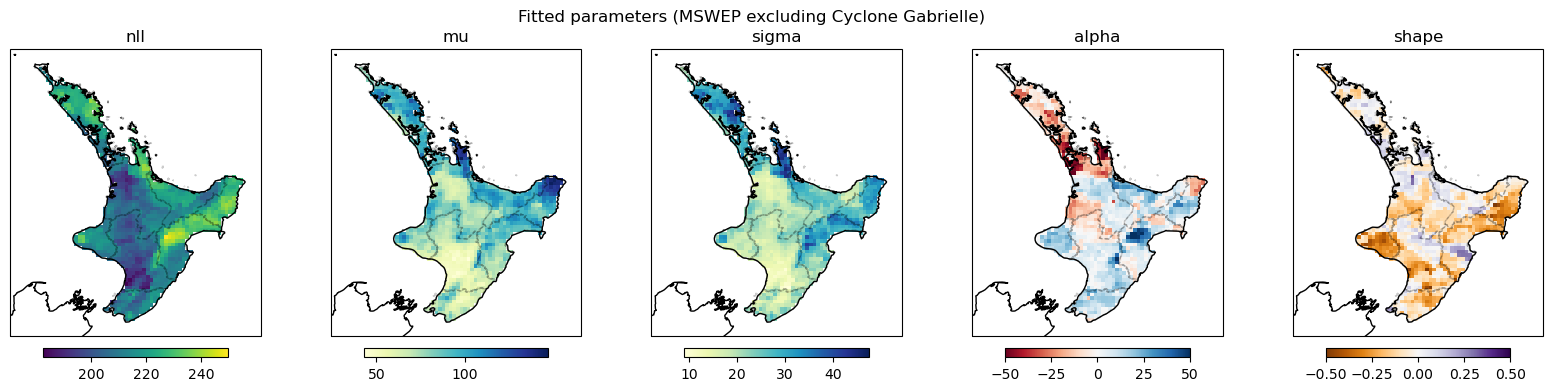

In [39]:
fitted_excl = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp_excluding-event.nc")
gmst = fitted_excl.covariate

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, fitted_excl.lon, fitted_excl.lat).sum("region")
mfit_excl = fitted_excl.ml_fit.assign_attrs(units = "").where(lsm == 1)

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(5):
    par = mfit.pars.values[i+1]
    cbar = axs[i].pcolormesh(mfit_excl.lon, mfit_excl.lat, mfit_excl.sel(pars = par), **plot_kwargs[par])
    plt.colorbar(cbar, ax = axs[i], location = "bottom", shrink = 0.9, fraction = 0.03, pad = 0.04)
    axs[i].set_title(par)
    axs[i].coastlines(color = "k")
    regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
    
# trend remains, suggesting not due to high leverage from Cyclone Gabrielle
plt.suptitle("Fitted parameters (MSWEP excluding Cyclone Gabrielle)")

Text(0.5, 0.98, 'Change in fitted parameters when Cyclone Gabrielle is included')

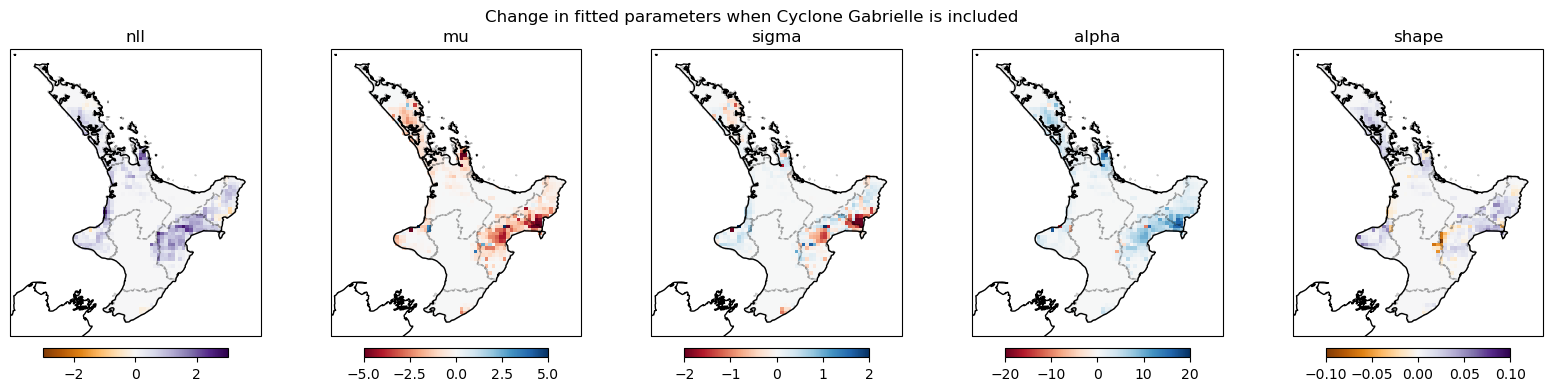

In [51]:
fit_diff = mfit - mfit_excl

fig, axs = plt.subplots(ncols = 5, figsize = (20,4), dpi = 100, sharey = False, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"nll" : {"cmap" : "PuOr", "vmin" : -3, "vmax" : 3},
               "mu" : {"cmap" : "RdBu", "vmin" : -5, "vmax" : 5},
               "sigma" : {"cmap" : "RdBu", "vmin" : -2, "vmax" : 2},
               "alpha" : {"cmap" : "RdBu", "vmin" : -20, "vmax" : 20},
               "shape" : {"cmap" : "PuOr", "vmin" : -0.1, "vmax" : 0.1}}
for i in range(5):
    par = mfit.pars.values[i+1]
    cbar = axs[i].pcolormesh(fit_diff.lon, fit_diff.lat, fit_diff.sel(pars = par), **plot_kwargs[par])
    plt.colorbar(cbar, ax = axs[i], location = "bottom", shrink = 0.9, fraction = 0.03, pad = 0.04)
    axs[i].set_title(par)
    axs[i].coastlines(color = "k")
    regions.boundary.plot(ax = axs[i], color = "k", lw = 1, ls = "--", alpha = 0.2)
    
# trend in wettest area is intensified, 
plt.suptitle("Change in fitted parameters when Cyclone Gabrielle is included")

<GeoAxesSubplot: title={'center': 'Change in intensity due to\nincluding Cyclone Gabrielle in the model fit'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

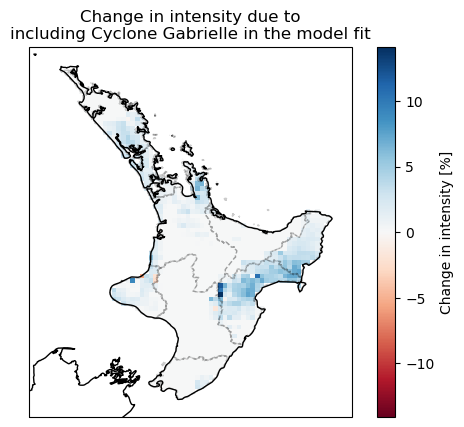

In [62]:
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")
event_rp = rpmap(mfit, event_value, gmst.sel(time = 2023))

rlev_incl = rlmap(mfit, event_rp, gmst.sel(time = 2023))
rlev_excl = rlmap(mfit_excl, event_rp, gmst.sel(time = 2023))

((rlev_incl - rlev_excl) / rlev_excl * 100).assign_attrs(long_name = "Change in intensity", units = "%").plot(cmap = "RdBu", subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
plt.title("Change in intensity due to\nincluding Cyclone Gabrielle in the model fit")
plt.gcf().axes[0].coastlines()
regions.boundary.plot(ax = plt.gcf().axes[0], color = "k", lw = 1, ls = "--", alpha = 0.2)



#### **Estimated return period of event**

In [4]:
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, event_value.lon, event_value.lat).sum("region")

mfit_with_event = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = mfit_with_event.covariate
mfit_with_event = mfit_with_event.ml_fit.where(lsm == 1)

mfit_excl_event = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp_excluding-event.nc").ml_fit.where(lsm == 1)

hg = gpd.read_file("sf_hawkes-gisborne")

In [5]:
event_rp = rpmap(mfit_with_event, event_value, gmst.sel(time = 2023))
event_rp_past = rpmap(mfit_with_event, event_value, gmst.sel(time = slice(None, 1990)).mean())

event_rp_excl = rpmap(mfit_excl_event, event_value, gmst.sel(time = 2023)).where(lsm == 1)

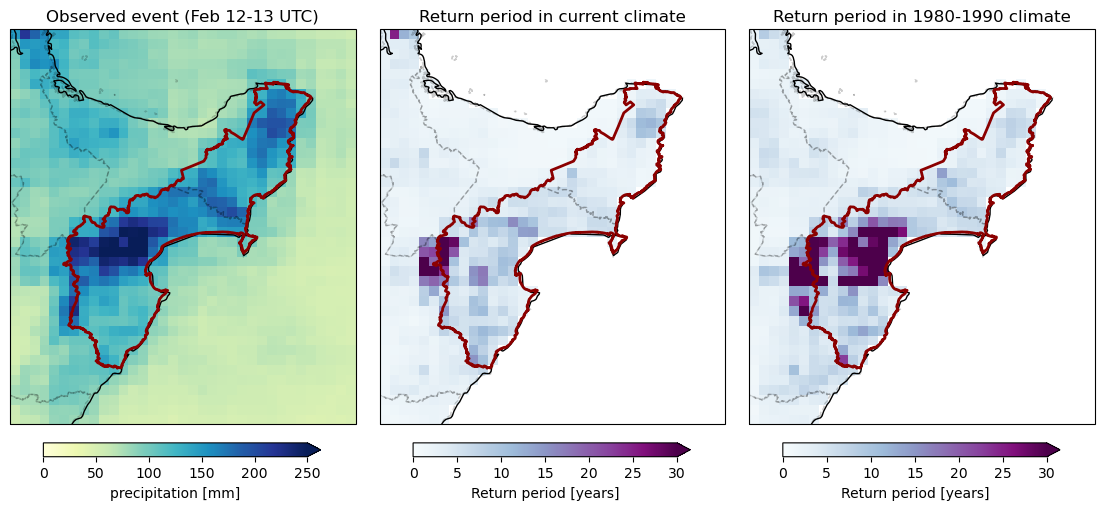

In [34]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (175.5,179,-37,-41)})
plt.subplots_adjust(wspace = 0.07)
cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}

event_value.plot(ax = axs[0], cmap = "YlGnBu", vmin = 0, vmax = 250, cbar_kwargs = cbar_kwargs); axs[0].set_title("Observed event (Feb 12-13 UTC)")
event_rp.plot(ax = axs[1], cmap = "BuPu", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[1].set_title("Return period in current climate")
event_rp_past.plot(ax = axs[2], cmap = "BuPu", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[2].set_title("Return period in 1980-1990 climate")
# event_rp_excl.plot(ax = axs[2], cmap = "Purples", cbar_kwargs = cbar_kwargs, vmin = 0, vmax = 30); axs[2].set_title("Return period excluding event")

for ax in axs:
    ax.coastlines(color = "k")
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred")
    
plt.savefig("mswep_rx2day_change-in-return-period.png")

#### **Estimated change in intensity**

In [25]:
mfit_with_event = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = mfit_with_event.covariate
mfit_with_event = mfit_with_event.ml_fit.where(lsm == 1)

# use fitted return period of observed event at each grid cell, rather than fixed return period
rlev_now = rlmap(mfit_with_event, event_rp, gmst.sel(time = 2023))
rlev_hist = rlmap(mfit_with_event, event_rp, gmst.sel(time = slice(None, 1990)).mean())

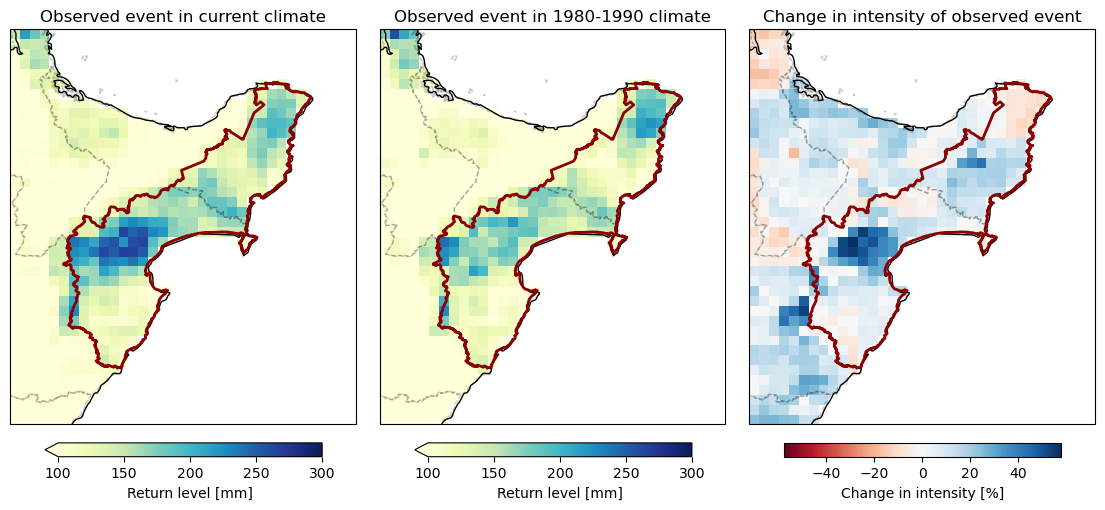

In [33]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,6), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (175.5,179,-37,-41)})
plt.subplots_adjust(wspace = 0.07)
cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 100, "vmax" : 300, "cbar_kwargs" : cbar_kwargs}

rlev_now.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("Observed event in current climate")
rlev_hist.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("Observed event in 1980-1990 climate")
((rlev_now - rlev_hist) / rlev_hist * 100).assign_attrs(long_name = "Change in intensity", units = "%").plot(ax = axs[2], cmap = "RdBu", cbar_kwargs = cbar_kwargs); axs[2].set_title("Change in intensity of observed event")

for ax in axs:
    ax.coastlines(color = "k")
    regions.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--", alpha = 0.2)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred")

### **Trend in Hawkes Bay/Gisborne regions**

In [279]:
df = pd.merge(pd.read_csv("ts/NZ-flood_rx2day_mswep_hg.dat", comment = "#", sep = " ", header = None, names = ["year", "rx2day"]), 
              pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"])).set_index("year")

event_gmst = df.loc[2023,"gmst"]
event_value = df.loc[2023,"rx2day"]

mdl = ns_fit(gev, "fixeddisp", df, "gmst", "rx2day")

event_rp = return_period(mdl, event_value, event_gmst)
past_rp = return_period(mdl, event_value, event_gmst-1.2)

dI = delta_I(mdl, event_rp, event_gmst, event_gmst - 1.2, relative = True)
pr = prob_ratio(mdl, event_value, event_gmst, event_gmst - 1.2)

print()
print("Return period in current climate:", int(event_rp))
print("Return period in past climate:", int(past_rp))
print()
print("Probability ratio:", pr.round(2))
print("Change in intensity:", dI.round(2),"%")
print()

# # bootstrap parameters
# boot_res = boot_results(mdl, event_gmst, event_gmst-1.2, event_value = event_value, rp = 11, relative_deltaI = True)
# boot_res.to_csv("boot-results_hawkes-gisborne")


Return period in current climate: 11
Return period in past climate: 50

Probability ratio: 4.43
Change in intensity: 31.63 %



/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


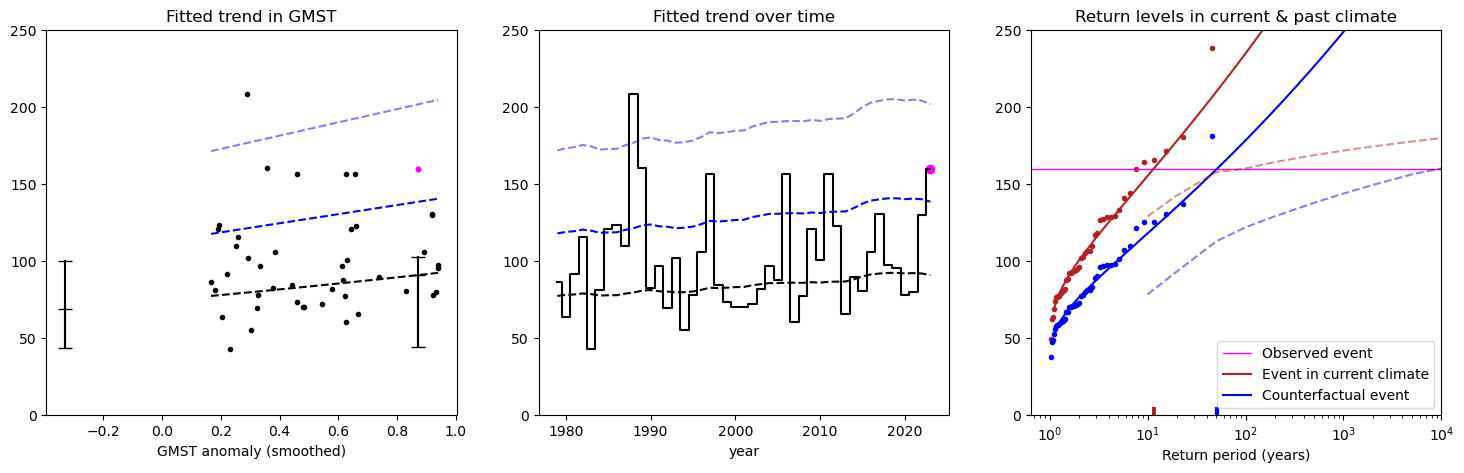

In [280]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

boot_res = pd.read_csv("boot-results_hawkes-gisborne")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ax = axs[2], ci_nsamp = 100)

for ax in axs: ax.set_ylim(0, 250)

axs[0].set_title("Fitted trend in GMST")
axs[1].set_title("Fitted trend over time")
axs[2].set_title("Return levels in current & past climate")

plt.savefig("mswep_rx2day_trendplots_hawkes-gisborne.png")

### **Nino3.4 correlation**

In [349]:
nino = pd.read_csv("../90_data/nino3.4_rel_monthly.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "nino34"], index_col = 0, parse_dates = True)
nino = nino.loc[[m in [12,1,2] for m in nino.index.month]].resample("AS-JUL", label = "right").mean()
nino.index = nino.index.year

rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day.rename(time = "year")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())
rx2day = rx2day.where(regionmask.mask_3D_geopandas(regions, rx2day.lon, rx2day.lat).sum("region") == 1)

hg = gpd.read_file("sf_hawkes-gisborne")

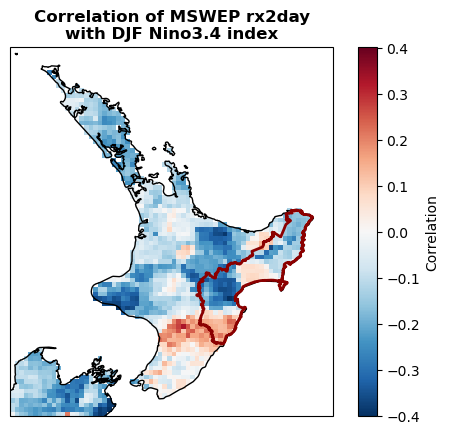

In [356]:
xr.corr(nino.to_xarray().nino34, rx2day, dim = "year").assign_attrs(long_name = "Correlation").plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
ax = plt.gcf().axes[0]

ax.coastlines()
hg.boundary.plot(ax = ax, color = "darkred", lw = 2)

plt.title("Correlation of MSWEP rx2day\nwith DJF Nino3.4 index", fontweight = "bold")

plt.savefig("nino3-4_correlation.png")

### **Esk Valley**

In [50]:
hg = gpd.read_file("sf_hawkes-gisborne/").set_crs(cartopy.crs.PlateCarree())
ev = gpd.read_file("sf/hybas_06/").loc[[969]].to_crs(cartopy.crs.PlateCarree()).clip(hg) # could also add region below (970)?

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


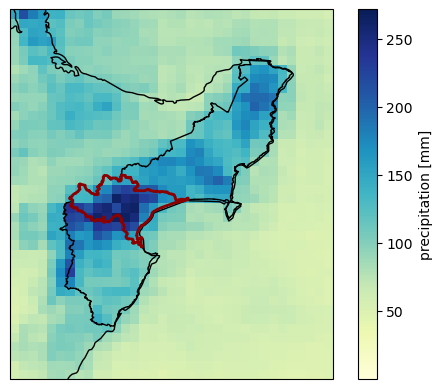

In [57]:
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

event_value.plot(cmap = "YlGnBu", subplot_kws = {"projection" : cartopy.crs.PlateCarree(), "extent" : (175.5,179,-37,-41)})
ax = plt.gcf().axes[0]
ax.coastlines()

hg.boundary.plot(ax = ax, color = "k", lw = 1)
ev.boundary.plot(ax = ax, color = "darkred", lw = 2)

plt.savefig("esk-valley-region.png")

In [53]:
rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day
rm = regionmask.mask_3D_geopandas(ev, rx2day.lon, rx2day.lat).squeeze(drop = True)
      
csv_fnm = "ts/NZ-flood_rx2day_mswep_esk-valley.dat"   

# create extra header lines for upload to Climate Explorer
str1 = "# contact :: MSWEP rx2day (Esk Valley) New Zealand flooding 2023, c.barnes22@imperial.ac.uk"
str2 = "# rx2day [mm] 2-day accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year rx2day"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

# get average precip over region of interest, accumulate over two days, get annual maximum
rx2day = rx2day.where(rm == 1).mean(["lat", "lon"])

rx2day.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

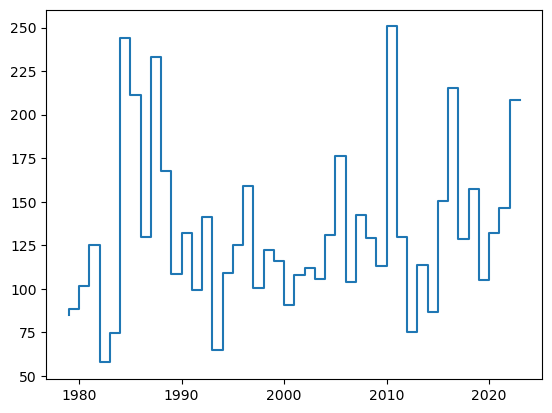

In [56]:
plt.step(rx2day.time, rx2day)

In [58]:
df = pd.merge(pd.read_csv("ts/NZ-flood_rx2day_mswep_esk-valley.dat", comment = "#", sep = " ", header = None, names = ["year", "rx2day"]), 
              pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"])).set_index("year")

In [60]:
event_gmst = df.loc[2023,"gmst"]
event_value = df.loc[2023,"rx2day"]

mdl = ns_fit(gev, "fixeddisp", df, "gmst", "rx2day")

event_rp = return_period(mdl, event_value, event_gmst)
past_rp = return_period(mdl, event_value, event_gmst-1.2)

dI = delta_I(mdl, event_rp, event_gmst, event_gmst - 1.2, relative = True)
pr = prob_ratio(mdl, event_value, event_gmst, event_gmst - 1.2)

print()
print("Return period in current climate:", int(event_rp))
print("Return period in past climate:", int(past_rp))
print()
print("Probability ratio:", pr.round(2))
print("Change in intensity:", dI.round(2),"%")
print()

# # bootstrap parameters
# boot_res = boot_results(mdl, event_gmst, event_gmst-1.2, event_value = event_value, rp = 11, relative_deltaI = True)
# boot_res.to_csv("boot-results_esk-valley.csv")


Return period in current climate: 8
Return period in past climate: 90

Probability ratio: 11.12
Change in intensity: 62.79 %



/home/clair/wwa/wwa_nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/ep
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/clair/wwa/wwa_nonstationary_fitting.py:276: RuntimeWarning: invalid value encountered in double_scalars
  pr = rp2/rp1


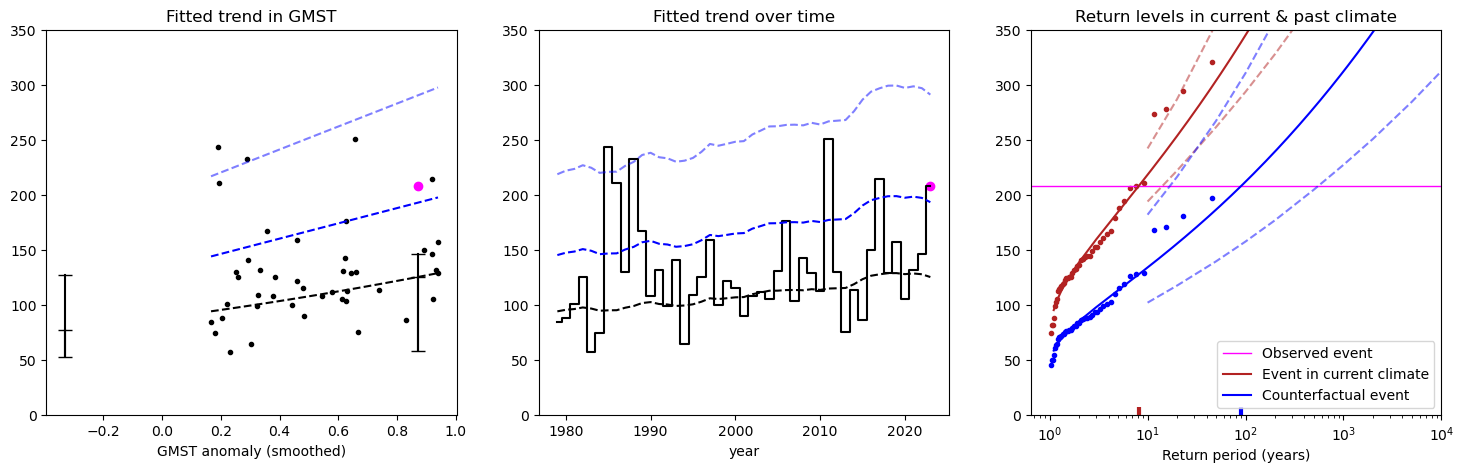

In [64]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

boot_res = pd.read_csv("boot-results_esk-valley.csv")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0], loc1 = boot_res.loc1, loc2 = boot_res.loc2)

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ax = axs[2], ci_nsamp = 10)

for ax in axs: ax.set_ylim(0, 350)

axs[0].set_title("Fitted trend in GMST")
axs[1].set_title("Fitted trend over time")
axs[2].set_title("Return levels in current & past climate")

plt.savefig("esk-valley_mswep_rx2day_trendplots.png")

---
## **Station data**


### **Council stations**
Additional time series provided by Sam Dean @ Niwa

In [81]:
# resample to daily frequency, write txt file interchangeable with NIWA data
stations = {"Aniwaniwa-Park" : 1, "Ngahere": 2, "Glenwood" : 3}

for fnm in glob.glob("stations/hbrc_*"):
    
    stn = fnm.split("_")[1][:-4]
    stn_id = stations[stn]
    csv_fnm = "stations/stn_"+str(stn_id)+".txt"
    
    stn_px = pd.read_csv(fnm, nrows = 2, sep = " = ", engine = "python", index_col = 0).transpose()
    stn_px = gpd.GeoDataFrame(stn_px, geometry = gpd.points_from_xy(stn_px.Easting, stn_px.Northing, crs = "epsg:2193")).to_crs(cartopy.crs.PlateCarree())
    
    # create extra header lines to match NIWA data
    str1 = "Station information:"
    str2 = "Name,Agent Number,Network Number,Latitude (dec.deg),Longitude (dec.deg),Height (m),Posn_Precision,Observing Authority"
    str3 = re.sub("-", " ", stn)+","+str(stn_id)+",-,"+str(stn_px.geometry.y.values[0])+","+str(stn_px.geometry.x.values[0])+",-,-,Council"
    str4 = "This space intentionally left blank"
    
    str5 = "Rain: Daily"
    str6 = "Station,Date(NZST),Time(NZST),Amount(mm),Rel,Orig,SofG,Deficit(mm),Runoff(mm),Rel,Orig,Period(Hrs),Freq"
    # 15876,19970912,0900,0.0,-,D,-,-,-,-,-,24,D
    
    # reshape time series to match format of NIWA data
    df = pd.read_csv(fnm, skiprows = 3, index_col = "Time (NZST)", parse_dates = True).resample("D").sum()
    stn_df = pd.DataFrame({"Station" : stn_id, "Date(NZST)": df.index.strftime("%Y%m%d"), "Time(NZST)":"0900", "Amount(mm)" : df["Rainfall Accumulation(mm)"].values}, index = range(len(df)))
   
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$str3" >> $csv_fnm
    ! echo "$str4" >> $csv_fnm
    ! echo "$str4" >> $csv_fnm
    ! echo "$str4" >> $csv_fnm
    ! echo "" >> $csv_fnm
    ! echo "$str5" >> $csv_fnm
    ! echo "$str6" >> $csv_fnm
    
    stn_df.to_csv(csv_fnm, mode = "a", header = False, index = False)

### **Selection of stations**

In [63]:
# load all station data, order by latitude
stn_data = pd.concat([pd.read_csv(fnm, skiprows = 1, nrows = 1, index_col = "Agent Number") for fnm in glob.glob("stations/stn_*.txt")]).rename(columns = {"Latitude (dec.deg)" : "lat", "Longitude (dec.deg)" : "lon"})
stn_data = stn_data.sort_values("lat", ascending = False)

# clip points to shapefile
stn_in_region = gpd.sjoin(gpd.GeoDataFrame(stn_data, geometry = gpd.points_from_xy(stn_data.lon, stn_data.lat)),
                          gpd.read_file("sf_hawkes-gisborne"), predicate = "within").index.to_list()
stn_data = stn_data.loc[stn_in_region]

stn_data.to_csv("stations/stationdata.csv")

In [65]:
# load observations, remove any not in study region
obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[13:-4]}) for fnm in glob.glob("stations/stn_*.txt")])
obs = obs[[str(s) for s in stn_data.index]].dropna(axis = 1, how = "all")

# identify stations that actually recorded the event
include = list(obs.loc[["2023-02-14"]].dropna(axis = 1, how = "any").columns)

# identify stations with obs as far back as 1980
long_ts = list(obs.loc[slice(None, "1980")].dropna(axis = 1, how = "all").columns)

# fix selected sites
include = ['1905', '24976', '1', '3126', '2', '2980', '15876', '3', '25820']
long_ts = ['2859', '2758', '2897', '2937', '2947', '2979', '3011', '3037', '3056', '3098', '3095', '2510', '2499', '2527', '2523']

print(include)

Text(0, 0.5, 'Station ID')

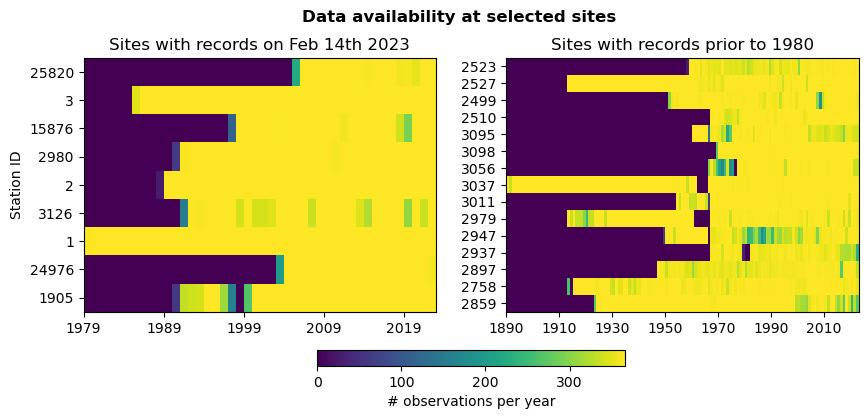

In [82]:
# check intactness of data

fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

n_obs_incl = obs.loc[slice(None, "2022"), include].dropna(axis = 0, how = "all").resample("AS-JAN").count()
n_obs_longts = obs.loc[slice(None, "2022"), long_ts].dropna(axis = 0, how = "all").resample("AS-JAN").count()

for i in range(2):
    
    stn_list = [include, long_ts][i]
    n_obs = obs.loc[slice(None, "2022"), stn_list].dropna(axis = 0, how = "all").resample("AS-JAN").count()
    
    ax = axs[i]
    cbar = ax.pcolormesh(n_obs.transpose())
    xticks = [x for x in ax.get_xticks() if x < len(n_obs)]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([n_obs.index.year[int(i)] for i in xticks])
    ax.set_yticks(ticks = [y + 0.5 for y in range(len(stn_list))])
    ax.set_yticklabels(stn_list)
    ax.set_title(["Sites with records on Feb 14th 2023", "Sites with records prior to 1980"][i])
    
    plt.suptitle("Data availability at selected sites", y = 1, fontweight = "bold")
    
plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.125, label = "# observations per year")
axs[0].set_ylabel("Station ID")
    
# sites that actually recorded the event have very short time series
# some missingness throughout, probably not at random

### **Map of selected stations**

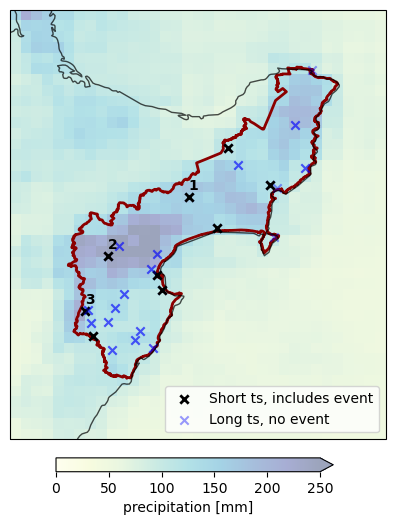

In [123]:
stn_data = pd.read_csv("stations/stationdata.csv", index_col = 0)

include = ['1905', '24976', '1', '3126', '2', '2980', '15876', '3', '25820']
long_ts = ['2859', '2758', '2897', '2937', '2947', '2979', '3011', '3037', '3056', '3098', '3095', '2510', '2499', '2527', '2523']


hg = gpd.read_file("sf_hawkes-gisborne")
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

cbar_kwargs = {"shrink" : 0.9}
fig, ax = plt.subplots(ncols = 1, figsize = (6,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

event_value.plot(ax = ax, cmap = "YlGnBu", alpha = 0.4, vmin = 0, vmax = 250, cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}, zorder = -2)

ax.coastlines(color = "k", alpha = 0.7)
hg.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)

stn_incl = stn_data.loc[[int(s) for s in include]]
stn_val = stn_data.loc[[int(s) for s in long_ts]]

ax.scatter(stn_data.lon, stn_data.lat, marker = "x", color = "blue", alpha = 0.4)

ax.scatter(stn_incl.lon, stn_incl.lat, marker = "x", color = "k", lw = 2, label = "Short ts, includes event")
ax.scatter(stn_val.lon, stn_val.lat, marker = "x", color = "blue", alpha = 0.4, label = "Long ts, no event")

# [ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold", color = "blue") for k,v in stn_data.iterrows()]
# [ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold") for k,v in stn_incl.iterrows()]
[ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold") for k,v in stn_incl.loc[[1,2,3]].iterrows()]

ax.legend(loc = "lower right")
plt.savefig("station-locations.png")


### **Validation of MSWEP vs stations**

In [124]:
obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[13:-4]}) for fnm in glob.glob("stations/stn_*.txt")])

# filter to selected stations
include = ['1905', '24976', '1', '3126', '2', '2980', '15876', '3', '25820']
long_ts = ['2859', '2758', '2897', '2937', '2947', '2979', '3011', '3037', '3056', '3098', '3095', '2510', '2499', '2527', '2523']
obs = obs[include + long_ts]

stn_data = pd.read_csv("stations/stationdata.csv", index_col = 0)

In [125]:
# get rx2day at each station (only interested in years from summer 1978-9 onwards)
rx2day_obs = obs.rolling(2).sum().resample("AS-JUL", label = "right").max()
rx2day_obs = rx2day_obs.set_index(rx2day_obs.index.year).loc[slice("1979", None)]
rx2day_obs = rx2day_obs.where(rx2day_obs > 0)

In [126]:
# load gridded data, extract time series at grid cell closest to station
mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day
mswep_stn = xr.concat([nearest_px(v.lon, v.lat, mswep).expand_dims(stn = [k]) for k,v in stn_data.iterrows()], "stn")

In [127]:
# count number of DJF days available each year
n_obs = obs.loc[[m in [12,1,2,3,4,5] for m in obs.index.month]].resample("AS-JUL", label = "right").count()
n_obs.iloc[-1] = 182
n_obs = n_obs.set_index(n_obs.index.year).loc[slice("1979", None)]

# filter time series - only include where most of DJFMAM was observed (can change this, but think this was wettest period?)
rx2day_obs = rx2day_obs.where(n_obs >= 165)

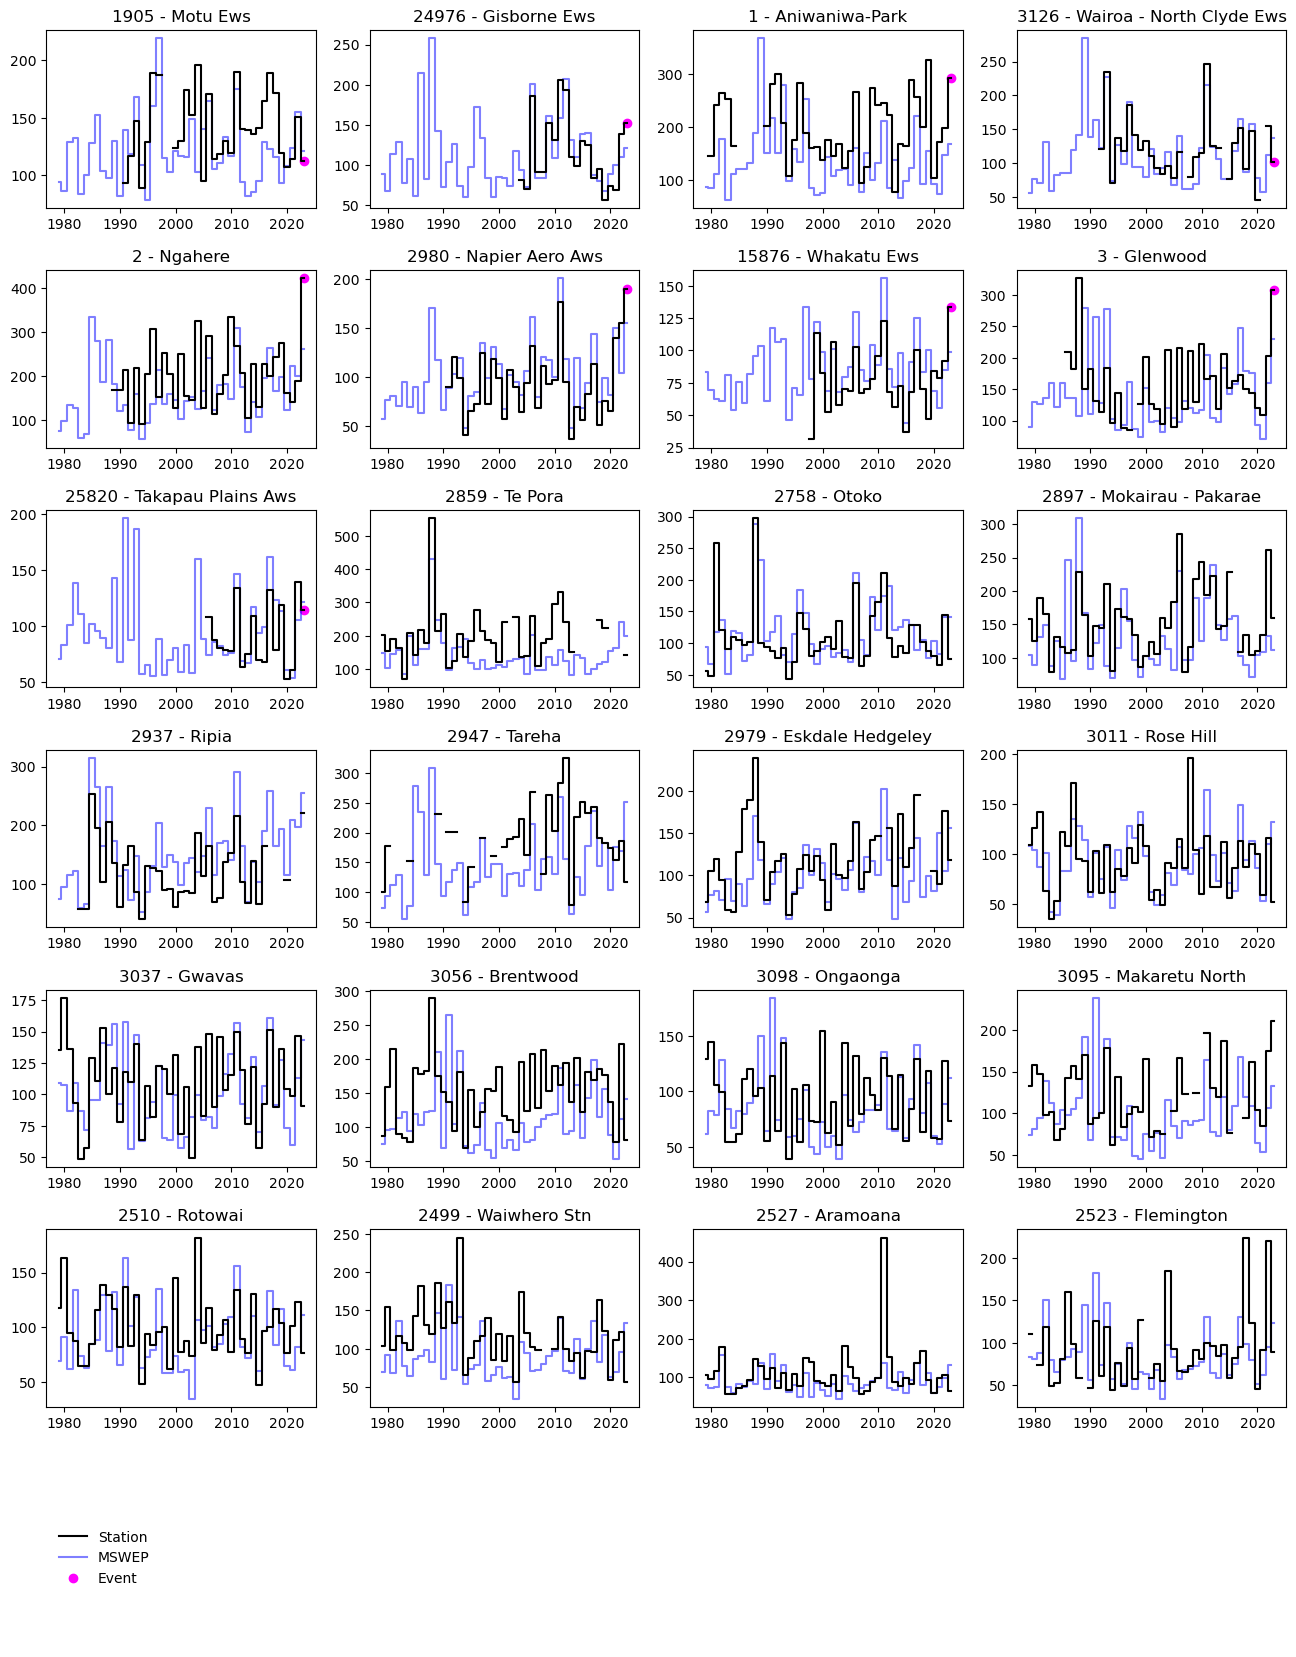

In [128]:
# plot of station data vs MSWEP grid cell data
nc = 4
nr = int(np.ceil(len(stn_data) / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr * 3), dpi = 100, sharey = False)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(rx2day_obs.columns)):
    
    ax = plt.gcf().axes[i]
    stn = rx2day_obs.columns[i]
            
    ax.step(mswep_stn.time, mswep_stn.sel(stn = int(stn)), color = "blue", alpha = 0.5, where = "mid")
    ax.step(rx2day_obs.index, rx2day_obs[stn], color = "k", where = "mid")
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    if stn in include:
        event_value = rx2day_obs.loc[2023,stn]
        ax.scatter(2023, rx2day_obs.loc[2023, stn], color = "magenta", label = "Event")
    
for i in range(len(rx2day_obs.columns), nc*nr): plt.gcf().axes[i].set_axis_off()

plt.gcf().axes[len(rx2day_obs.columns)].legend(handles = [matplotlib.lines.Line2D([], [], color = "k", label = "Station"),
                                                          matplotlib.lines.Line2D([], [], color = "blue", alpha = 0.5, label = "MSWEP"),
                                                          matplotlib.lines.Line2D([], [], color = "magenta", marker = "o", ls = "", label = "Event")],
                                               loc = "center left", edgecolor = "w")
    
plt.savefig("mswep-station-validation.png")

### **Underestimation of event vs stations**


In [24]:
# load council data, get coordinates & value of Feb 14th event
council_px = []
for fnm in sorted(glob.glob("council-stations/*.csv")):
    
    # load coordinates
    px = pd.read_csv(fnm, nrows = 2, sep = " = ", engine = "python", index_col = 0).transpose()
    px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(px.Easting, px.Northing, crs = "epsg:2193")).to_crs(cartopy.crs.PlateCarree())
    
    # load event value
    px["value"] = pd.read_csv(fnm, skiprows = 3, index_col = "Time (NZST)", parse_dates = True).resample("D").sum().rolling(2, center = False).sum().loc["2023-02-14"].values
    council_px.append(px)
    
px = pd.concat(council_px)
px["lon"] = px.geometry.x
px["lat"] = px.geometry.y

In [25]:
# add in stations from cliflo that include the event
stn_data = pd.read_csv("stations/stationdata.csv", index_col = 0).loc[[1905, 24976, 3126, 2980, 15876]]
stn_data["value"] = [pd.read_csv("stations/stn_"+str(s)+".txt", skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rolling(2, center = False).sum().loc["2023-02-14"][0] for s in stn_data.index]

df = pd.concat([px, stn_data.set_index("Name")[["geometry", "lon", "lat", "value"]]])

px.to_csv("data/station-obs-of-event.csv")

#### **Map of underestimates at station locations**

In [26]:
hg = gpd.read_file("sf_hawkes-gisborne")
obs = pd.read_csv("data/station-obs-of-event.csv", index_col = 0)
obs = obs.where(obs.value > 6)
mswep_event = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

# load gridded data, extract time series at grid cell closest to station
mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day.sel(time = 2023).squeeze(drop = True)

obs["mswep"] = xr.concat([nearest_px(v.lon, v.lat, mswep).expand_dims(stn = [k]) for k,v in obs.iterrows()], "stn")

In [27]:
# mean underestimation
1 / (1 + (obs.mswep - obs.value).mean() / obs.value.mean())

1.5116946416163892

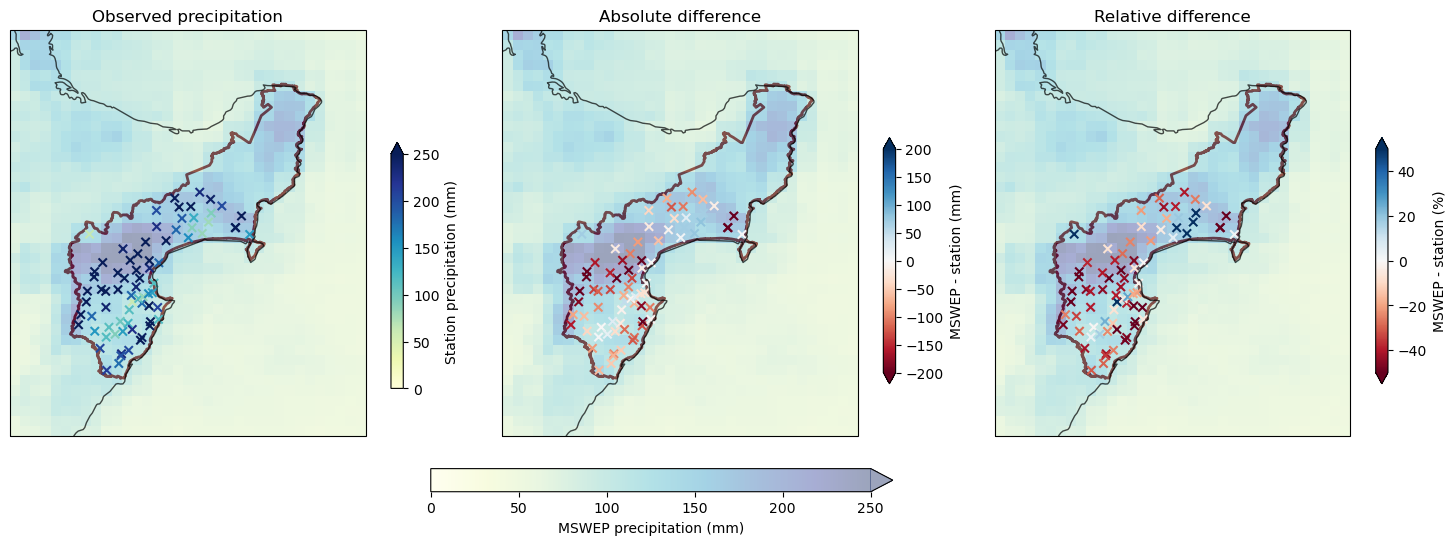

In [343]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

for ax in axs:
    mswep_cbar = mswep_event.plot(ax = ax, cmap = "YlGnBu", alpha = 0.4, vmin = 0, vmax = 250, add_colorbar = False)
    ax.coastlines(color = "k", alpha = 0.7)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)
    
cbar_kwargs = {"shrink" : 0.95, "fraction" : 0.03, "pad" : 0.02}

pr_cbar = axs[0].scatter(obs.lon, obs.lat, marker = "x", c = obs.value, cmap="YlGnBu", vmin = 0, vmax = 250)
plt.colorbar(pr_cbar, ax = axs[0], **cbar_kwargs | {"extend" : "max", "label" : "Station precipitation (mm)"})
axs[0].set_title("Observed precipitation")

diff_cbar = axs[1].scatter(obs.lon, obs.lat, marker = "x", c = (obs.mswep - obs.value), cmap="RdBu", vmin = -200, vmax = 200)
plt.colorbar(diff_cbar, ax = axs[1], **cbar_kwargs | {"label" : "MSWEP - station (mm)", "extend" : "both"})
axs[1].set_title("Absolute difference")

rel_cbar = axs[2].scatter(obs.lon, obs.lat, marker = "x", c = (obs.mswep - obs.value) / obs.value * 100, cmap="RdBu", vmin = -50, vmax = 50)
plt.colorbar(rel_cbar, ax = axs[2], **cbar_kwargs | {"label" : "MSWEP - station (%)", "extend" : "both"})
axs[2].set_title("Relative difference")

plt.colorbar(mswep_cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.07, label = "MSWEP precipitation (mm)", extend = "max")

plt.savefig("local-underestimation-relative.png")

In [30]:
hg = gpd.read_file("sf_hawkes-gisborne/").set_crs(cartopy.crs.PlateCarree())
ev = gpd.read_file("sf/hybas_06/").loc[[968,969,970,971]].to_crs(cartopy.crs.PlateCarree()).clip(hg)[["geometry"]] # could also add region below (970)?

ev_stations = gpd.sjoin(gpd.GeoDataFrame(obs, geometry = gpd.points_from_xy(obs.lon, obs.lat), crs = ev.crs), ev, predicate = "within")

# adjustment needed to correct MSWEP over this region:
m_adj = (ev_stations.mswep - ev_stations.value).mean() / ev_stations.value.mean()

# check this conversion:
(ev_stations.mswep.mean() / (m_adj + 1)).round(0) == ev_stations.value.mean().round(0)

# extrapolating this trend across the whole region would give 216mm accumulated precip
print(m_adj)
159.84 / (m_adj + 1)

# even saying a 10% underestimate would move this from rp10 to rp20
# 20% underestimate gives rp40 for this event

-0.3342086186015262


/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


240.07520143060597

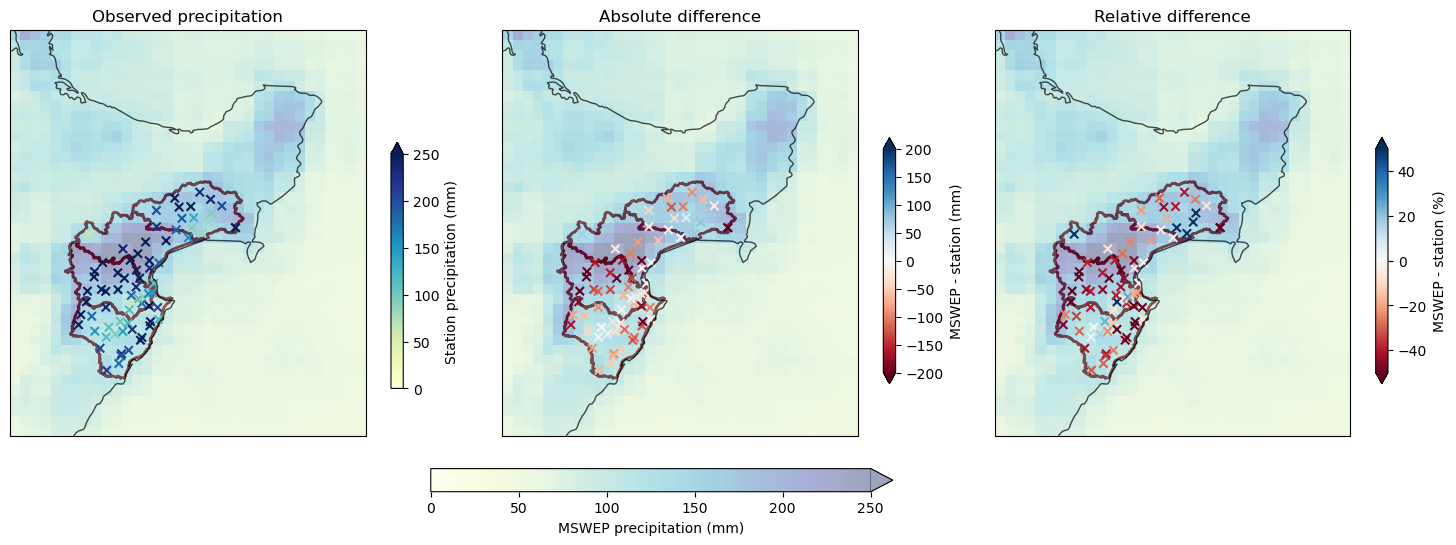

In [419]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

for ax in axs:
    mswep_cbar = mswep_event.plot(ax = ax, cmap = "YlGnBu", alpha = 0.4, vmin = 0, vmax = 250, add_colorbar = False)
    ax.coastlines(color = "k", alpha = 0.7)
    # hg.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)
    ev.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)

cbar_kwargs = {"shrink" : 0.95, "fraction" : 0.03, "pad" : 0.02}

pr_cbar = axs[0].scatter(ev_stations.lon, ev_stations.lat, marker = "x", c = ev_stations.value, cmap="YlGnBu", vmin = 0, vmax = 250)
plt.colorbar(pr_cbar, ax = axs[0], **cbar_kwargs | {"extend" : "max", "label" : "Station precipitation (mm)"})
axs[0].set_title("Observed precipitation")

diff_cbar = axs[1].scatter(ev_stations.lon, ev_stations.lat, marker = "x", c = (ev_stations.mswep - ev_stations.value), cmap="RdBu", vmin = -200, vmax = 200)
plt.colorbar(diff_cbar, ax = axs[1], **cbar_kwargs | {"label" : "MSWEP - station (mm)", "extend" : "both"})
axs[1].set_title("Absolute difference")

rel_cbar = axs[2].scatter(ev_stations.lon, ev_stations.lat, marker = "x", c = (ev_stations.mswep - ev_stations.value) / ev_stations.value * 100, cmap="RdBu", vmin = -50, vmax = 50)
plt.colorbar(rel_cbar, ax = axs[2], **cbar_kwargs | {"label" : "MSWEP - station (%)", "extend" : "both"})
axs[2].set_title("Relative difference")

plt.colorbar(mswep_cbar, ax = axs, location = "bottom", shrink = 0.9, fraction = 0.05, pad = 0.07, label = "MSWEP precipitation (mm)", extend = "max")

plt.savefig("adjustment-estimation-relative.png")

### **Station return periods**

In [284]:
# load council data, get rx2day time series
stn_rx2day = []
for fnm in sorted(glob.glob("council-stations/*.csv")):
    
    # load event value
    df = pd.read_csv(fnm, skiprows = 3, index_col = "Time (NZST)", parse_dates = True).resample("D").sum()
    
    # load coordinates
    px = pd.read_csv(fnm, nrows = 2, sep = " = ", engine = "python", index_col = 0).transpose()
    px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(px.Easting, px.Northing, crs = "epsg:2193")).to_crs(cartopy.crs.PlateCarree())
    
    if not "2023-02-14" in df.index: continue    # must include event
    if df.index.year.min() > 2002: continue      # must have at least 20 years of data
    
    df = df.rolling(2, center = False).sum().resample("AS-JUL", label = "right").max()
    df = df.where(df > 0).dropna(axis = 0, how = "any")
    df.index = df.index.year
    df = df.rename(columns = {"Rainfall Accumulation(mm)" : re.sub(".csv", "", fnm.split("/")[-1])})
        
    stn_rx2day.append(df)

for fnm in sorted(glob.glob("stations/stn_*.txt"))[:2]:
    if len(fnm) == 18: continue
    
    stn = fnm[13:-4]
    df = pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : stn})
    
    if not "2023-02-14" in df.index: continue    # must include event
    if df.index.year.min() > 2002: continue      # must have at least 20 years of data
    
    df = df.rolling(2, center = False).sum().resample("AS-JUL", label = "right").max()
    df = df.where(df > 0).dropna(axis = 0, how = "any")
    df.index = df.index.year
    
    stn_rx2day.append(df)

stn_rx2day = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'), stn_rx2day)
stn_rx2day.to_csv("data/station_rx2day.csv")

In [330]:
stn_rx2day = pd.read_csv("data/station_rx2day.csv", index_col = 0)
gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = 0)

event_gmst = gmst.loc[2023, "gmst"]
gmst_hist = gmst.loc[slice(1980,1990), "gmst"].mean()

In [ ]:
stn_rp = {}
for c in stn_rx2day.columns:
    
    df = pd.merge(gmst, stn_rx2day[[c]].dropna(axis = 0, how = "any"), left_index = True, right_index = True)
    event_value = df.loc[2023, c]

    mlfit = ns_fit(gev, "fixeddisp", df, "gmst", c)
    ml20 = ns_fit(gev, "fixeddisp", df[-20:], "gmst", c)
    
    stn_rp[c] = {"n_obs" : len(df), 
                 "rp_all" : return_period(mlfit, event_value, event_gmst),
                 "rp_20" : return_period(ml20, event_value, event_gmst), 
                 "rp_hist" : return_period(ml20, event_value, gmst_hist), 
                 "event_value" : event_value}

pd.DataFrame(stn_rp).transpose().to_csv("data/station_rx2day_return-times.csv")

In [332]:
stn_rp = pd.read_csv("data/station_rx2day_return-times.csv", index_col = 0)

# add coordinates to fitted RPs
px = pd.read_csv("data/station-obs-of-event.csv", index_col = 0)[["lon", "lat"]]
px.index = [s[1:] for s in px.index]
px = pd.concat([px, pd.read_csv("stations/stationdata.csv", index_col = 0).loc[[15876], ["lon", "lat"]]])
px.index = [str(s) for s in px.index]

stn_px = pd.merge(px, stn_rp, left_index = True, right_index = True)

In [334]:
hg = gpd.read_file("sf_hawkes-gisborne")
mswep_event = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

regions = gpd.read_file("sf/nz_regions/").to_crs(cartopy.crs.PlateCarree())[:9]
lsm = regionmask.mask_3D_geopandas(regions, mswep_event.lon, mswep_event.lat).sum("region")

mfit_with_event = xr.open_dataset("fitted_models/mswep_rx2day_fitted-gev-fixeddisp.nc")
gmst = mfit_with_event.covariate
mfit_with_event = mfit_with_event.ml_fit.where(lsm == 1)

event_rp = rpmap(mfit_with_event, mswep_event, gmst.sel(time = 2023))
event_rp_hist = rpmap(mfit_with_event, mswep_event, gmst.sel(time = slice(None, 1990)).mean())

In [448]:
stn_px["mswep_rp"] = [nearest_px(v.lon, v.lat, event_rp).values.tolist() for k, v in stn_px.iterrows()]
stn_px["mswep_rphist"] = [nearest_px(v.lon, v.lat, event_rp_hist).values.tolist() for k, v in stn_px.iterrows()]
stn_px["mswep_value"] = [nearest_px(v.lon, v.lat, mswep_event).values.tolist() for k, v in stn_px.iterrows()]

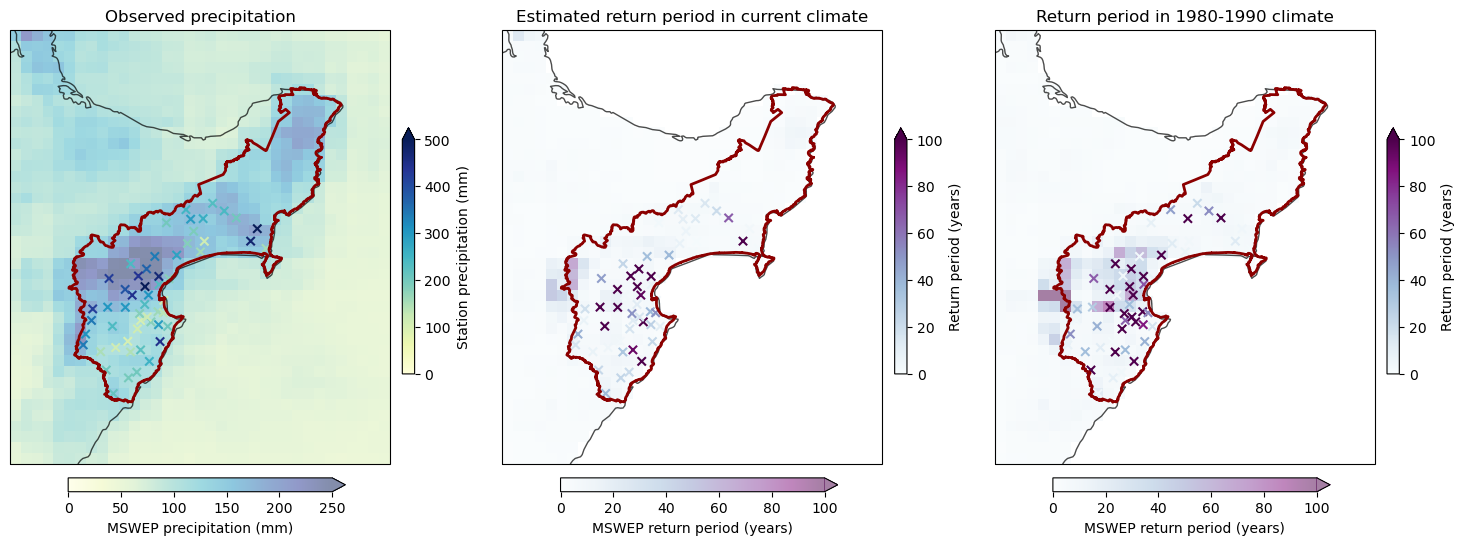

In [472]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

cbar_kwargs = {"shrink" : 0.95, "fraction" : 0.03, "pad" : 0.03}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_event.plot(ax = axs[0], cmap = "YlGnBu", alpha = 0.5, vmin = 0, vmax = 250, 
                 cbar_kwargs = cbar_kwargs | { "location" : "bottom", "label" : "MSWEP precipitation (mm)", "extend" : "max"})

pr_cbar = axs[0].scatter(stn_ests.lon, stn_ests.lat, marker = "x", c = stn_ests.event_value, cmap="YlGnBu", vmin = 0, vmax = 500)
plt.colorbar(pr_cbar, ax = axs[0], **cbar_kwargs | {"extend" : "max", "label" : "Station precipitation (mm)"})
axs[0].set_title("Observed precipitation")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

event_rp.plot(ax = axs[1], cmap = "BuPu", alpha = 0.5, vmin = 0, vmax = 100, 
                 cbar_kwargs = cbar_kwargs | { "location" : "bottom", "label" : "MSWEP return period (years)", "extend" : "max"})
rp_cbar = axs[1].scatter(stn_ests.lon, stn_ests.lat, marker = "x", c = stn_ests.rp_all, cmap = "BuPu", vmin = 0, vmax = 100)
plt.colorbar(rp_cbar, ax = axs[1], **cbar_kwargs | {"label" : "Return period (years)", "extend" : "max"})
axs[1].set_title("Estimated return period in current climate")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

event_rp_hist.plot(ax = axs[2], cmap = "BuPu", alpha = 0.5, vmin = 0, vmax = 100, 
                 cbar_kwargs = cbar_kwargs | { "location" : "bottom", "label" : "MSWEP return period (years)", "extend" : "max"})
rph_cbar = axs[2].scatter(stn_ests.lon, stn_ests.lat, marker = "x", c = stn_ests.rp_hist, cmap = "BuPu", vmin = 0, vmax = 100)
plt.colorbar(rp_cbar, ax = axs[2], **cbar_kwargs | {"label" : "Return period (years)", "extend" : "max"})
axs[2].set_title("Return period in 1980-1990 climate")

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred")
    
plt.savefig("station-return-periods_incl-hist.png")

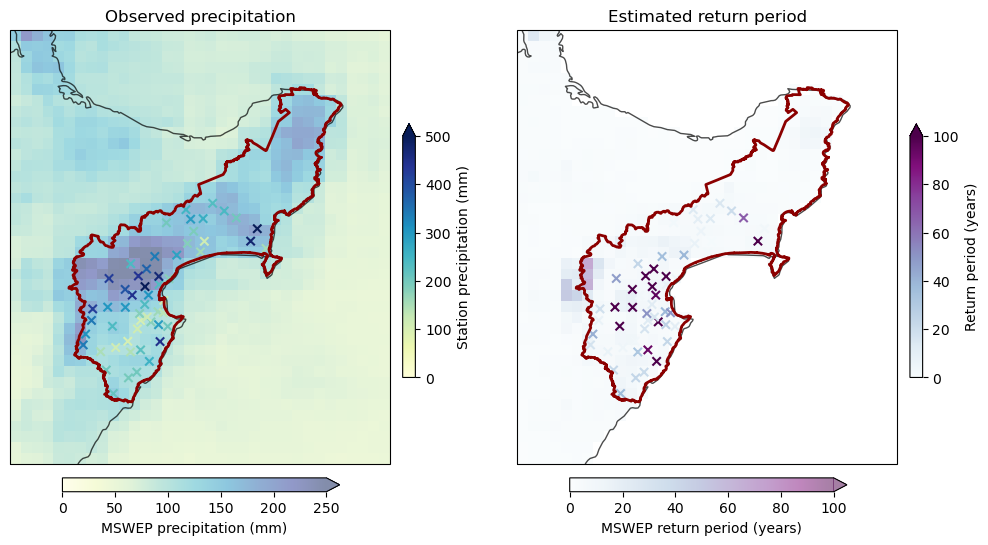

In [474]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

cbar_kwargs = {"shrink" : 0.95, "fraction" : 0.03, "pad" : 0.03}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_event.plot(ax = axs[0], cmap = "YlGnBu", alpha = 0.5, vmin = 0, vmax = 250, 
                 cbar_kwargs = cbar_kwargs | { "location" : "bottom", "label" : "MSWEP precipitation (mm)", "extend" : "max"})

pr_cbar = axs[0].scatter(stn_ests.lon, stn_ests.lat, marker = "x", c = stn_ests.event_value, cmap="YlGnBu", vmin = 0, vmax = 500)
plt.colorbar(pr_cbar, ax = axs[0], **cbar_kwargs | {"extend" : "max", "label" : "Station precipitation (mm)"})
axs[0].set_title("Observed precipitation")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

event_rp.plot(ax = axs[1], cmap = "BuPu", alpha = 0.5, vmin = 0, vmax = 100, 
                 cbar_kwargs = cbar_kwargs | { "location" : "bottom", "label" : "MSWEP return period (years)", "extend" : "max"})
rp_cbar = axs[1].scatter(stn_ests.lon, stn_ests.lat, marker = "x", c = stn_ests.rp_all, cmap = "BuPu", vmin = 0, vmax = 100)
plt.colorbar(rp_cbar, ax = axs[1], **cbar_kwargs | {"label" : "Return period (years)", "extend" : "max"})
axs[1].set_title("Estimated return period")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines(color = "k", alpha = 0.7)
    hg.boundary.plot(ax = ax, lw = 2, color = "darkred")
    
plt.savefig("station-return-periods.png")

In [470]:
print("Station max: "+str(int(stn_px.event_value.max()))+"mm")
print("MSWEP max (across entire region): "+str(int(mswep_event.max()))+"mm")
print("")
print("Comparison of stations with corresponding MSWEP grid cells:")
print("   Station mean: "+str(int(stn_px.event_value.mean()))+"mm ("+str(round(stn_px.event_value.std(),1))+")")
print("   MSWEP mean: "+str(int(stn_px.mswep_value.mean()))+"mm ("+str(round(stn_px.mswep_value.std(),1))+")")
print("")
print("   Average station RP: "+str(int(stn_px.rp_all.mean()))+" ("+str(round(stn_px.rp_all.std(),1))+")")
print("   Average MSWEP RP: "+str(int(stn_px.mswep_rp.mean()))+" ("+str(round(stn_px.mswep_rp.std(),1))+")")

stn_px.round().loc[stn_px.rp_20 < 10000,["event_value", "mswep_rp", "rp_all", "n_obs"]].sort_values("event_value", ascending = False)

In [476]:
(stn_px.n_obs > 40).sum()

9

In [480]:
long_ts_stations = stn_px.loc[stn_px.n_obs > 40].index.to_list()

#### **Fitted return periods**

In [302]:
gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = 0)

In [ ]:
council_ts = []
for stn in sorted(long_ts_stations):
        
    # load event value
    df = pd.read_csv("council-stations/"+stn+".csv", skiprows = 3, index_col = "Time (NZST)", parse_dates = True).resample("D").sum().rolling(2, center = False).sum().resample("AS-JUL", label = "right").max()
    df = df.where(df > 0).dropna(axis = 0, how = "any")
    df.index = df.index.year
    df = df.rename(columns = {"Rainfall Accumulation(mm)" : stn})
        
    council_ts.append(df)

council_ts = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'), council_ts)

In [532]:
rx2day = xr.open_dataset("data/mswep_rx2day.nc").rx2day
mswep_council_ts = xr.concat([nearest_px(*stn_px.loc[stn, ["lon", "lat"]].values, rx2day).expand_dims(stn = [stn]) for stn in sorted(long_ts_stations)], "stn")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


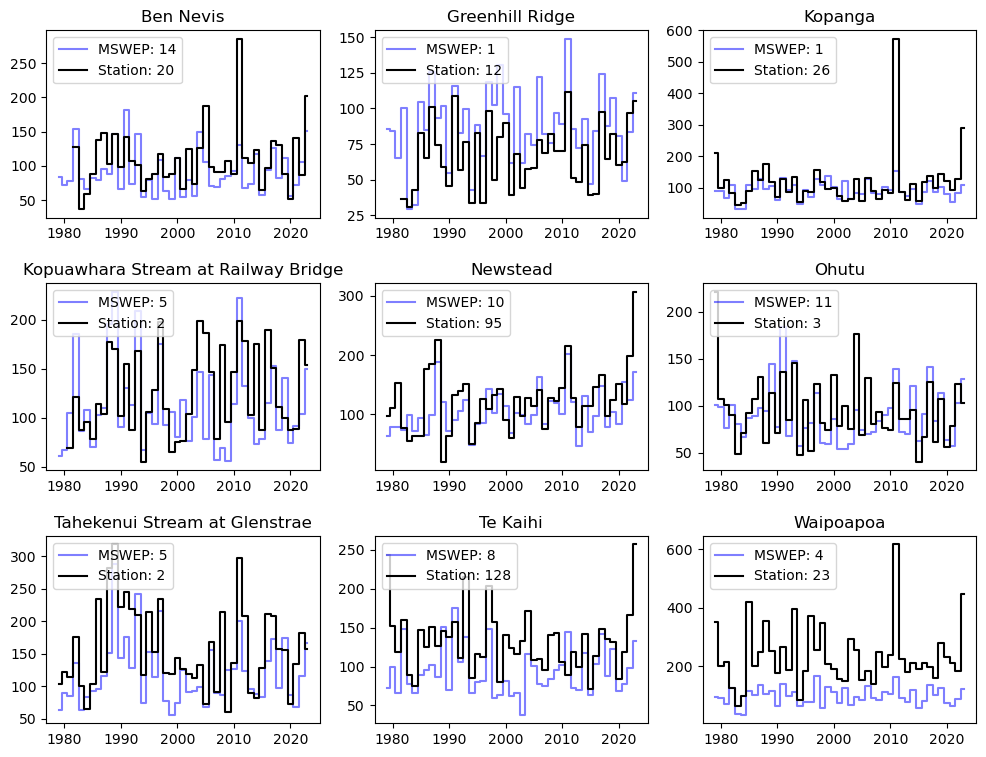

In [558]:
# plot of station data vs MSWEP grid cell data
nc = 3
nr = int(np.ceil(len(long_ts_stations) / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr * 3), dpi = 100, sharey = False)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(council_ts.columns)):
    
    ax = plt.gcf().axes[i]
    stn = council_ts.columns[i]
    
    df = pd.merge(gmst, stn_rx2day[[stn]].dropna(axis = 0, how = "any"), left_index = True, right_index = True)
    stn_event = df.loc[2023, [stn]]
    stn_fit = ns_fit(gev, "fixeddisp", df, "gmst", stn)

    mswep_df = pd.merge(gmst, mswep_council_ts.sel(stn = stn).to_dataframe()[["rx2day"]], left_index = True, right_index = True)
    mswep_event = mswep_df.loc[2023, ["rx2day"]]
    mswep_fit = ns_fit(gev, "fixeddisp", mswep_df, "gmst", "rx2day")
            
    ax.step(mswep_council_ts.time, mswep_council_ts.sel(stn = stn), color = "blue", alpha = 0.5, where = "mid", label = "MSWEP: "+str(int(return_period(mswep_fit, mswep_event, event_gmst))))
    ax.step(council_ts.index, council_ts[stn], color = "k", where = "mid", label = "Station: "+str(int(return_period(stn_fit, stn_event, event_gmst))))
    ax.set_title(stn)
    ax.legend(loc = "upper left")
    
plt.savefig("station-mswep-rp.png")

### **Trends in stations in wettest regions**

In [ ]:
# long_ts stations, filtered to reduce density of stations in drier regions
stn_1979 = ['2859', '2758', '2897', '1',  '2', '2980', '2937', '2947', '2979', '3011', '3056', "3", '3098', '3095', '2510',"3037"]   # Removed: ['3037', '2527', '2523', '2499']

obs = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'),
            [pd.read_csv(fnm, skiprows = 8, index_col = "Date(NZST)", parse_dates = True)[["Amount(mm)"]].rename(columns = {"Amount(mm)" : fnm[13:-4]}) for fnm in glob.glob("stations/stn_*.txt")])[stn_1979].dropna(axis = 0, how = "all")
stn_data = pd.read_csv("stations/stationdata.csv", index_col = 0).loc[[int(s) for s in stn_1979]]

hg = gpd.read_file("sf_hawkes-gisborne")
event_value = xr.open_dataset("data/mswep-daily_2023.nc").precipitation.sel(time = slice("2023-02-12", "2023-02-13")).sum("time").assign_attrs(units = "mm")

# load gridded data, extract time series at grid cell closest to station
mswep = xr.open_dataset("data/mswep_rx2day.nc").rx2day
mswep_stn = xr.concat([nearest_px(v.lon, v.lat, mswep).expand_dims(stn = [k]) for k,v in stn_data.iterrows()], "stn")

# data cleaning, based on known/suspected issues at individual sites
obs.loc[slice(None, "1980"),["2937"]] = np.nan   # clear change in variability after 1980, when gauge was run over by new owner & replaced
obs.loc[slice(None, "1966-07"),["3011"]] = np.nan   # clear change in variability after late 1966, when observation type changed
obs.loc[slice(None, "1966"),["2979"]] = np.nan  # change in variability after break in readings in 1966

# now get rx2day at each site
rx2day_obs = obs.rolling(2).sum().resample("AS-JUL", label = "right").max()
rx2day_obs = rx2day_obs.set_index(rx2day_obs.index.year)
rx2day_obs = rx2day_obs.where(rx2day_obs > 0)

#### **Map & plot selected stations**

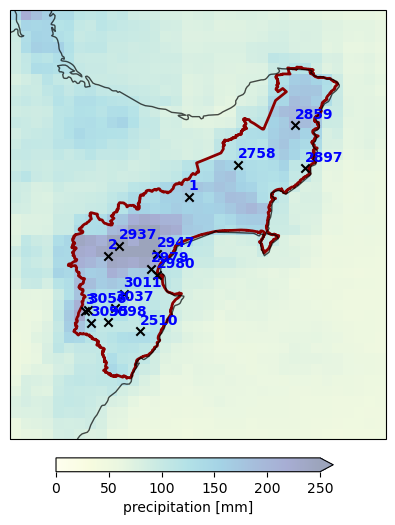

In [300]:
cbar_kwargs = {"shrink" : 0.9}
fig, ax = plt.subplots(ncols = 1, figsize = (6,6), dpi = 100,
                       subplot_kw = {"projection" : cartopy.crs.PlateCarree(), 
                                     "extent" : (175.5,179,-37,-41)})

event_value.plot(ax = ax, cmap = "YlGnBu", alpha = 0.4, vmin = 0, vmax = 250, cbar_kwargs = {"location" : "bottom", "shrink" : 0.9, "fraction" : 0.03, "pad" : 0.04}, zorder = -2)

ax.coastlines(color = "k", alpha = 0.7)
hg.boundary.plot(ax = ax, lw = 2, color = "darkred", zorder = -1)

ax.scatter(stn_data.lon, stn_data.lat, marker = "x", color = "k")
[ax.annotate(k, xy = [v.lon, v.lat], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold", color = "blue") for k,v in stn_data.iterrows()]

plt.savefig("station-locations_long-ts.png")

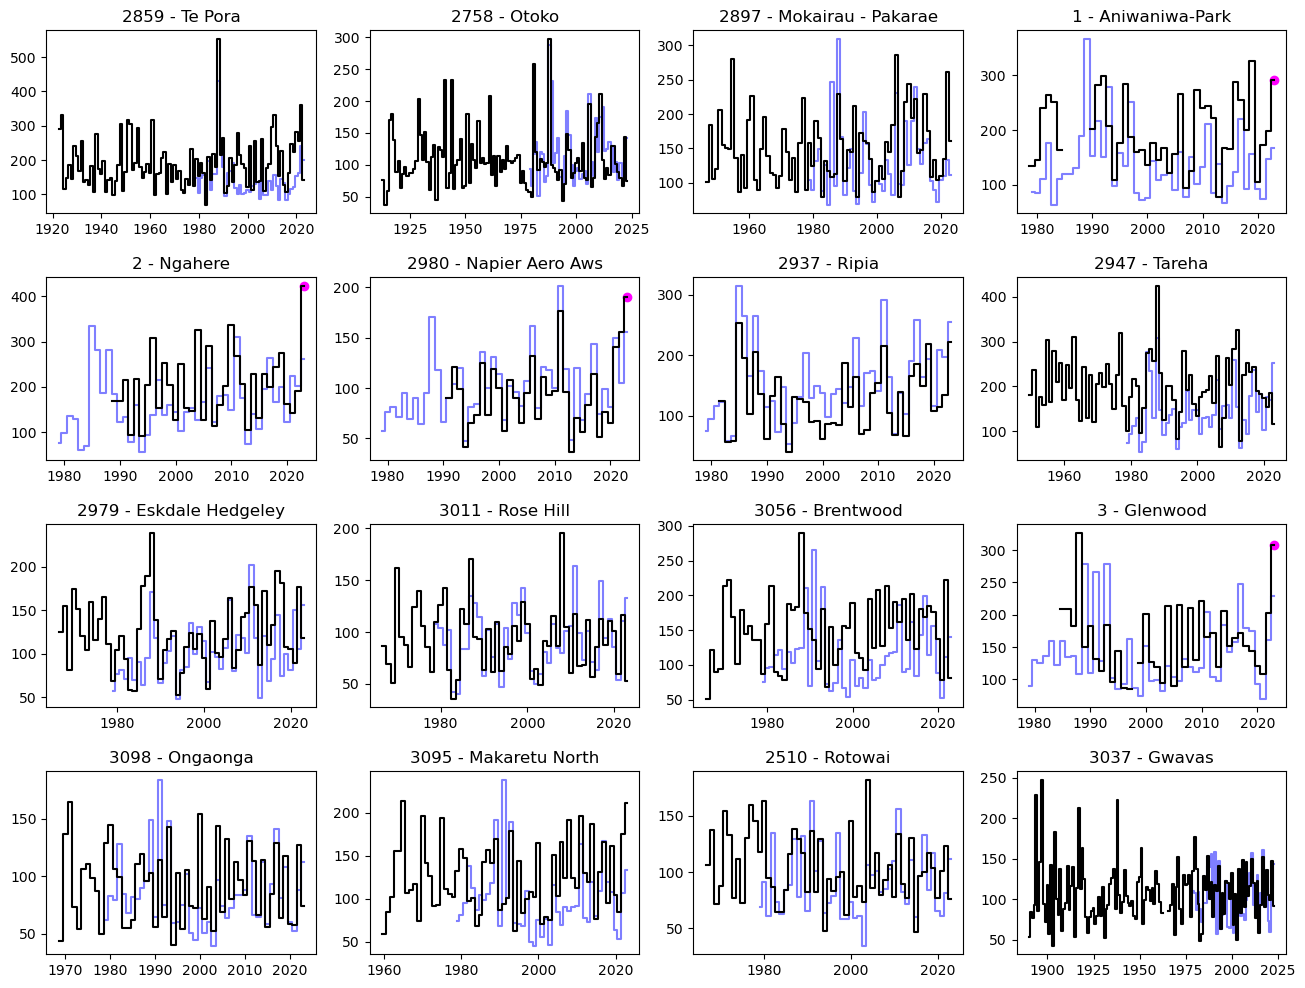

In [301]:
# plot of station data vs MSWEP grid cell data
nc = 4
nr = int(np.ceil(len(stn_data) / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr * 3), dpi = 100, sharey = False)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(rx2day_obs.columns)):
    
    ax = plt.gcf().axes[i]
    stn = rx2day_obs.columns[i]
            
    ax.step(mswep_stn.time, mswep_stn.sel(stn = int(stn)), color = "blue", alpha = 0.5, where = "mid")
    ax.step(rx2day_obs.index, rx2day_obs[stn], color = "k", where = "mid")
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    if stn in include:
        event_value = rx2day_obs.loc[2023,stn]
        ax.scatter(2023, rx2day_obs.loc[2023, stn], color = "magenta", label = "Event")

#### **Fitted trends**

In [302]:
gmst = pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = 0)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


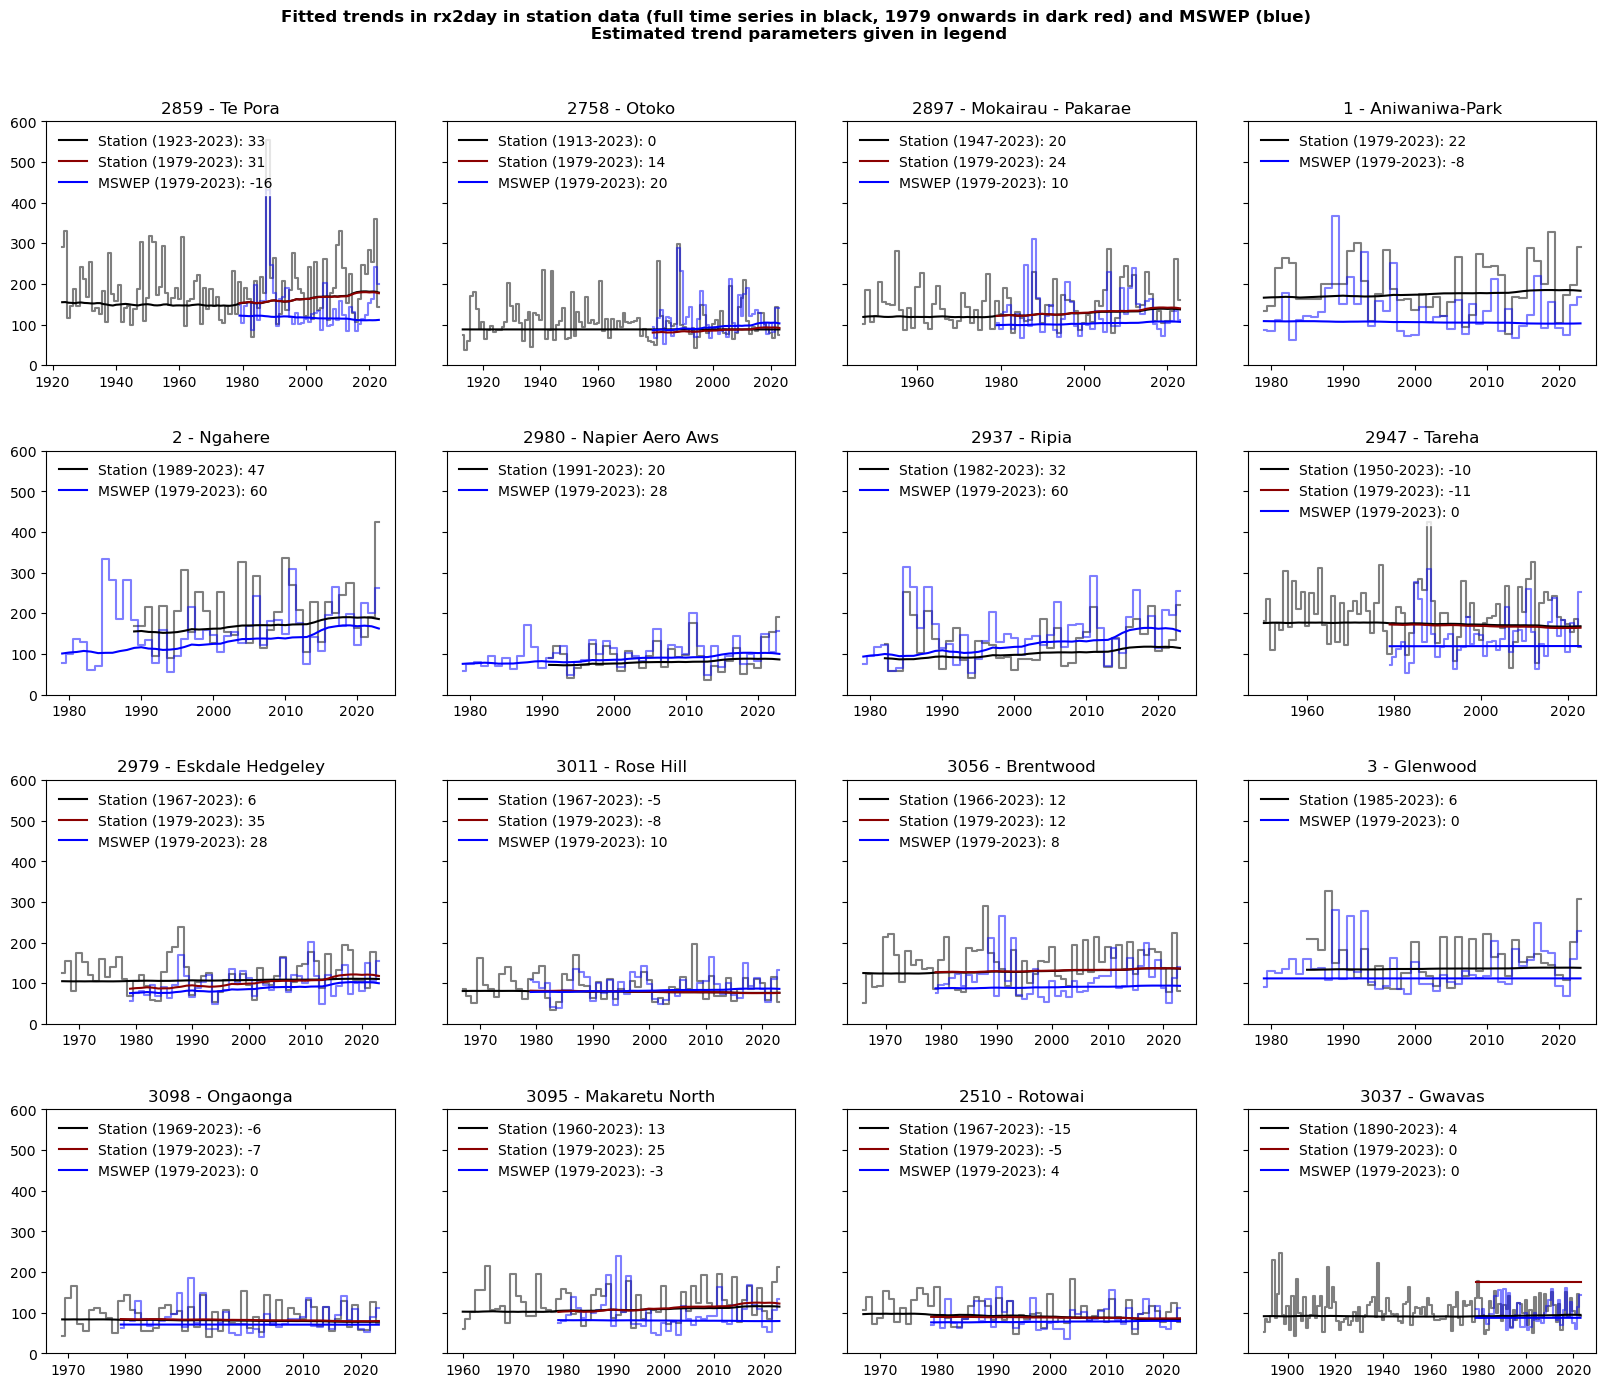

In [303]:
nc = 4
nr = int(np.ceil(len(stn_data) / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr * 4), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.35, wspace = 0.15)

for i in range(len(rx2day_obs.columns)):
    
    ax = plt.gcf().axes[i]
    stn = rx2day_obs.columns[i]
        
    # fit models to available data - exclude 2023 from MSWEP, since not available in most stations
    mswep_df = pd.merge(gmst, mswep_stn.sel(stn = int(stn), drop = True).to_dataframe(), left_index = True, right_index = True)#.loc[slice(None, 2022)]
    mswep_fit = ns_fit(gev, "fixeddisp", mswep_df, "gmst", "rx2day")
    
    stn_df = pd.merge(gmst, rx2day_obs[[stn]].dropna(axis = 0, how = "any"), left_index = True, right_index = True)
    stn_fit = ns_fit(gev, "fixeddisp", stn_df, "gmst", stn)
    stn1979_fit = ns_fit(gev, "fixeddisp", stn_df.loc[slice(1979, None)], "gmst", stn)
    
    ax.step(stn_df.index, stn_df[[stn]], color = "k", where = "mid", alpha = 0.5)
    ax.step(mswep_df.index, mswep_df.rx2day, color = "blue", where = "mid", alpha = 0.5)

    ns_pars(stn_fit)["loc"].plot(ax = ax, color = "k", label = "Station ("+str(stn_df.index[0])+"-2023): "+str(int(stn_fit["results"].pars["alpha"])))
    
    if stn_df.index[0] < 1979:
        ns_pars(stn1979_fit)["loc"].plot(ax = ax, color = "darkred", label = "Station (1979-2023): "+str(int(stn1979_fit["results"].pars["alpha"])))
    ns_pars(mswep_fit)["loc"].plot(ax = ax, color = "blue", label = "MSWEP (1979-"+str(mswep_df.index[-1])+"): "+str(int(mswep_fit["results"].pars["alpha"])))
    
    ax.set_title(stn+" - "+stn_data.loc[int(stn)].Name)
    ax.legend(loc = "upper left", edgecolor = "w")
    
plt.ylim(0,600)
    
plt.suptitle("Fitted trends in rx2day in station data (full time series in black, 1979 onwards in dark red) and MSWEP (blue)\n Estimated trend parameters given in legend", y = 0.95, fontweight = "bold")
plt.savefig("station-fitted-trends.png")

## **Station composite**

In [32]:
stn = xr.open_dataset("data/HawkesBayGisborneDailyRainfall.nc").total_precip.resample(time = "D").sum().rolling(time = 2).sum()
mswep = xr.open_dataset("data/mswep_daily-ts.nc").precipitation.rolling(time = 2).sum()

In [159]:
rx2day_stn, rx2day_mswep = [da.resample(time = "AS-JUL", label = "right").max() for da in [stn, mswep]]
rx2day_stn.assign_coords(time = rx2day_stn.time.dt.year).rename("rx2day").to_dataframe().loc[slice(1979,None)].to_csv("station-composite-ts.txt", sep = " ")

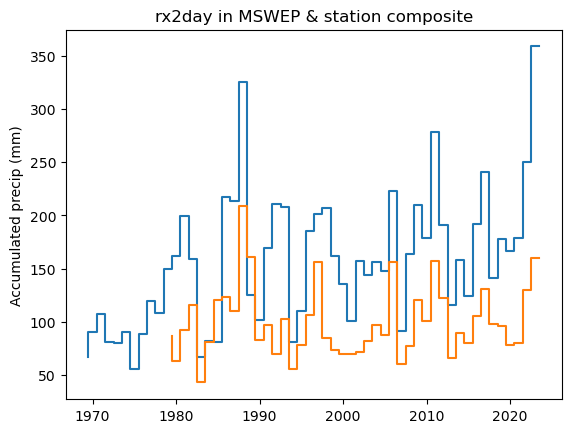

In [75]:
plt.step(rx2day_stn.time, rx2day_stn, label = "Station composite")
plt.step(rx2day_mswep.time, rx2day_mswep, label = "MSWEP")
plt.ylabel("Accumulated precip (mm)")
plt.title("rx2day in MSWEP & station composite")

plt.savefig("station-composite_rx2day.png")

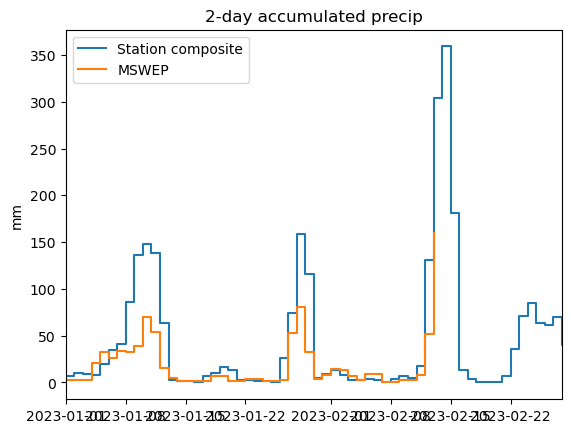

In [73]:
plt.step(stn.time, stn, label = "Station composite")
plt.step(mswep.time, mswep, label = "MSWEP", where = "post")

plt.xlim(datetime(2023,1,1), datetime(2023,2,28))

plt.legend()
plt.ylabel("mm")
plt.title("2-day accumulated precip")
plt.savefig("station-composite_last-six-months.png")

### **Fitted trends**

In [134]:
stn_df, mswep_df = [pd.merge(da.assign_coords(time = da.time.dt.year).rename("rx2day").to_dataframe(), 
                             pd.read_csv("../90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["year","gmst"], index_col = 0),
                             left_index = True, right_index = True).loc[slice(1979, None)] for da in [rx2day_stn, rx2day_mswep]]

event_gmst = stn_df.loc[2023,"gmst"]
stn_value, mswep_value = [df.loc[2023,"rx2day"] for df in [stn_df, mswep_df]]

# fit model to each dataset
stn_mdl, mswep_mdl = [ns_fit(gev, "fixeddisp", df, "gmst", "rx2day") for df in [stn_df, mswep_df]]

In [150]:
print("dI in stations:", delta_I(stn_mdl, 50, event_gmst, event_gmst - 1.2, relative = True).round())
print("dI in MSWEP:", delta_I(mswep_mdl, 50, event_gmst, event_gmst - 1.2, relative = True).round())
print()
print("PR in stations:", prob_ratio(stn_mdl, 50, event_gmst, event_gmst - 1.2, relative = True).round())

In [154]:
prob_ratio(stn_mdl, stn_value, event_gmst, event_gmst - 1.2)
prob_ratio(mswep_mdl, stn_value, event_gmst, event_gmst - 1.2)

158.5818830483057

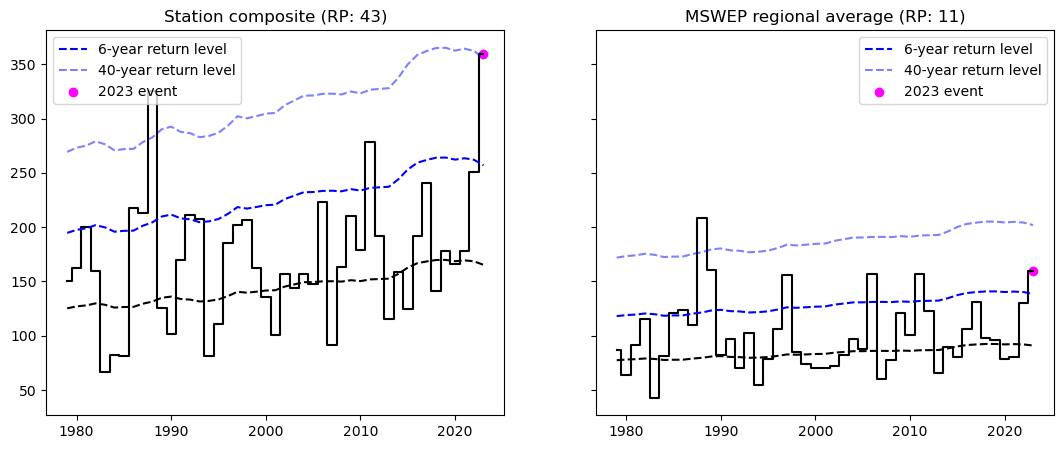

In [152]:
fig, axs = plt.subplots(ncols = 2, figsize = (13,5), dpi = 100, sharey = True)

for i in range(2):
    
    ax = axs[i]
    df = [stn_df, mswep_df][i]
    mdl = [stn_mdl, mswep_mdl][i]
    
    ax.step(df.index, df.rx2day, color = "k", where = "mid")
    ns_pars(mdl)["loc"].plot(ax = ax, color = "k", ls = "--", label = "_")
    ax.plot(df.index, return_level(mdl, 6), color = "blue", ls = "--", label = "6-year return level")
    ax.plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5, label = "40-year return level")
    ax.scatter(2023, df.loc[2023, "rx2day"], color = "magenta", label = "2023 event")
    
    ax.legend()
    
axs[0].set_title("Station composite (RP: "+str(int(return_period(stn_mdl, stn_value, event_gmst)))+")")
axs[1].set_title("MSWEP regional average (RP: "+str(int(return_period(mswep_mdl, mswep_value, event_gmst)))+")")

plt.savefig("station-composite_trendplots.png")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


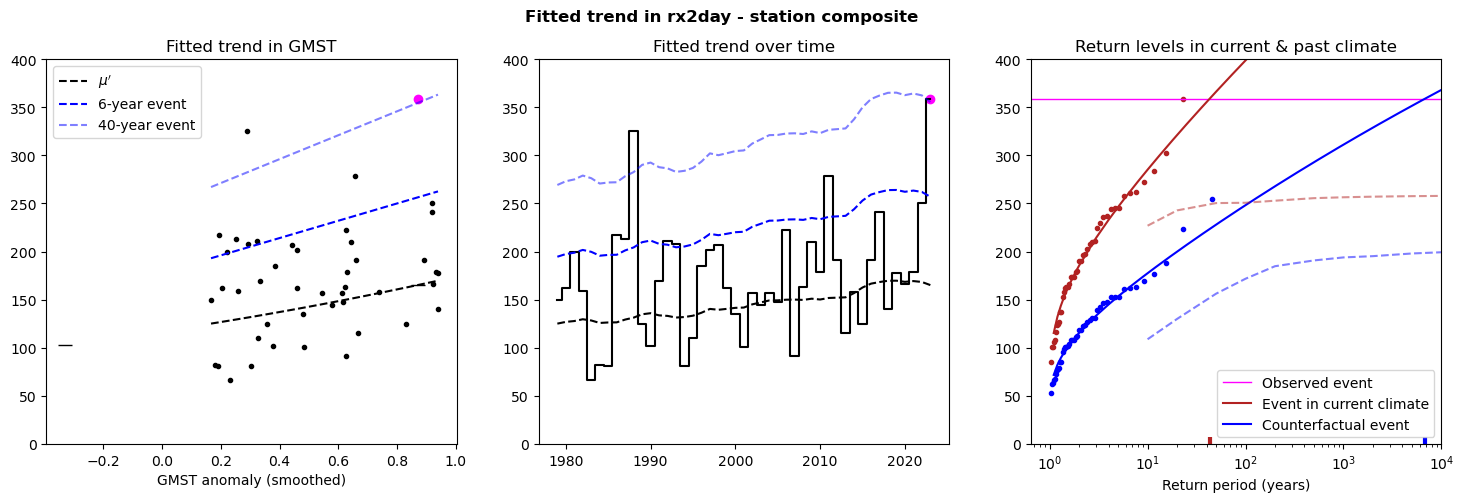

In [190]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

mdl = stn_mdl; event_value = stn_value; df = stn_df

axs[0].set_title("Fitted trend in GMST")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0])
axs[0].legend()

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
axs[1].set_title("Fitted trend over time")

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ax = axs[2], ci_nsamp = 500)
axs[2].set_title("Return levels in current & past climate")

for ax in axs: ax.set_ylim(0, 400)
plt.suptitle("Fitted trend in rx2day - station composite", fontweight = "bold")

plt.savefig("station-composite_rx2day_trendplots.png")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


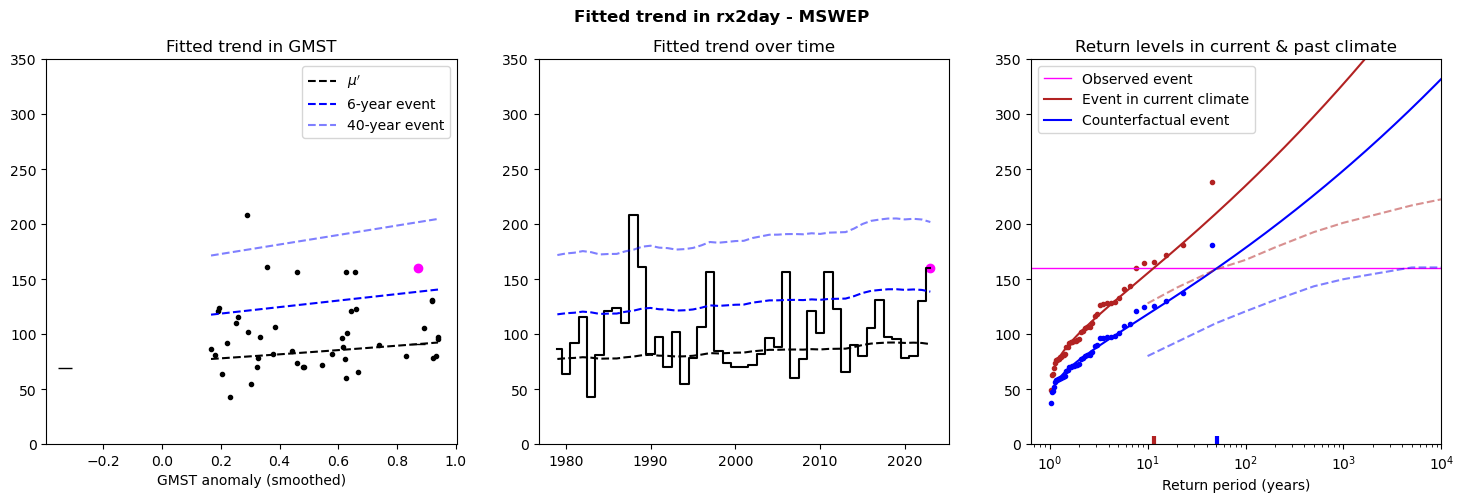

In [191]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,5), dpi = 100, sharey = False)

mdl = mswep_mdl; event_value = mswep_value; df = mswep_df

axs[0].set_title("Fitted trend in GMST")
trendplot(mdl, event_gmst, event_gmst-1.2, ax = axs[0])
axs[0].legend()

axs[1].step(df.index, df.rx2day, color = "k", where = "mid")
ns_pars(mdl)["loc"].plot(ax = axs[1], color = "k", ls = "--")
axs[1].plot(df.index, return_level(mdl, 6), color = "blue", ls = "--")
axs[1].plot(df.index, return_level(mdl, 40), color = "blue", ls = "--", alpha = 0.5)
axs[1].scatter(2023, df.loc[2023, "rx2day"],color = "magenta")
axs[1].set_title("Fitted trend over time")

rlplot(mdl, event_gmst, event_gmst-1.2, event_value, ax = axs[2], ci_nsamp = 500)
axs[2].set_title("Return levels in current & past climate")

for ax in axs: ax.set_ylim(0, 350)
plt.suptitle("Fitted trend in rx2day - MSWEP", fontweight = "bold")
plt.savefig("mswep_rx2day_trendplots.png")